In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

2025-01-25 02:48:02.683665: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-25 02:48:02.683734: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 02:48:02.683774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 02:48:02.692581: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install --upgrade matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [3]:
train_df = pd.read_csv('../newKDDTrain+.txt', header=None)

columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
# Rename the columns of the DataFrame
train_df.columns = columns

train_df.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate    class  
0                      0.00   normal  
1                      0.00   normal  
2                      0.00  anomaly  
3                      0.01   normal  
4                      0.00   normal  

[5 rows x 42 columns]

In [4]:
test_df = pd.read_csv('../newKDDTest+.txt', header=None)

test_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
# Rename the columns of the DataFrame
test_df.columns = columns

test_df.head()

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  10   
1               0       0    0  ...                   1   
2               0       0    0  ...                  86   
3               0       0    0  ...                  57   
4               0       0    0  ...                  86   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61                    0.04   
3                    1.00                    0.00   
4                    0.31                    0.17   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.00                         0.00   
1                         0.00                         0.00   
2                         0.61                         0.02   
3                         1.00                         0.28   
4                         0.03                         0.02   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                  1.00   
1                   0.0                       0.0                  1.00   
2                   0.0                       0.0                  0.00   
3                   0.0                       0.0                  0.00   
4                   0.0                       0.0                  0.83   

   dst_host_srv_rerror_rate    class  
0                      1.00  anomaly  
1                      1.00  anomaly  
2                      0.00   normal  
3                      0.00  anomaly  
4                      0.71  anomaly  

[5 rows x 42 columns]

In [5]:
kdd_df = pd.concat([train_df, test_df])

In [6]:
kdd_df.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate    class  
0                      0.00   normal  
1                      0.00   normal  
2                      0.00  anomaly  
3                      0.01   normal  
4                      0.00   normal  

[5 rows x 42 columns]

In [7]:
train_df = pd.read_csv("../UNSW-NB15/UNSW_NB15_training-set.csv")

In [8]:
test_df = pd.read_csv("../UNSW-NB15/UNSW_NB15_testing-set.csv")

In [9]:
unsw_df=pd.concat([train_df, test_df], axis=0)

In [10]:
kdd_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [11]:
unsw_df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [12]:
kdd_df['service'].value_counts()

http         48191
private      26627
domain_u      9937
smtp          8247
ftp_data      7711
             ...  
tftp_u           4
http_8001        2
aol              2
harvest          2
http_2784        1
Name: service, Length: 70, dtype: int64

In [13]:
# 각 데이터셋의 컬럼 분포(값의 범위) 확인

def dataset_column_distribution(df, dataset_name):
    print(f"\n{dataset_name} Dataset Column Distributions:\n")
    for column in df.columns:
        col_data = df[column]
        if col_data.dtype in ['int64', 'float64']:
            print(f"{column}: Min={col_data.min()}, Max={col_data.max()}, Mean={col_data.mean():.2f}, Std={col_data.std():.2f}")
        else:
            print(f"{column}: Non-numeric column, Unique Values={col_data.nunique()}")

# KDD 데이터셋 컬럼 분포 확인
dataset_column_distribution(kdd_df, "KDD")

# CIC-IDS 데이터셋 컬럼 분포 확인
dataset_column_distribution(unsw_df, "UNSW-NB15")


KDD Dataset Column Distributions:

duration: Min=0, Max=57715, Mean=276.78, Std=2460.68
protocol_type: Non-numeric column, Unique Values=3
service: Non-numeric column, Unique Values=70
flag: Non-numeric column, Unique Values=11
src_bytes: Min=0, Max=1379963888, Mean=40227.95, Std=5409611.60
dst_bytes: Min=0, Max=1309937401, Mean=17088.85, Std=3703524.78
land: Min=0, Max=1, Mean=0.00, Std=0.01
wrong_fragment: Min=0, Max=3, Mean=0.02, Std=0.24
urgent: Min=0, Max=3, Mean=0.00, Std=0.02
hot: Min=0, Max=101, Mean=0.19, Std=2.01
num_failed_logins: Min=0, Max=5, Mean=0.00, Std=0.07
logged_in: Min=0, Max=1, Mean=0.40, Std=0.49
num_compromised: Min=0, Max=7479, Mean=0.26, Std=22.23
root_shell: Min=0, Max=1, Mean=0.00, Std=0.04
su_attempted: Min=0, Max=2, Mean=0.00, Std=0.04
num_root: Min=0, Max=7468, Mean=0.27, Std=22.69
num_file_creations: Min=0, Max=100, Mean=0.01, Std=0.52
num_shells: Min=0, Max=5, Mean=0.00, Std=0.03
num_access_files: Min=0, Max=9, Mean=0.00, Std=0.10
num_outbound_cmds: Mi

In [14]:
kdd_df['protocol_type'].value_counts()

tcp     121569
udp      17614
icmp      9334
Name: protocol_type, dtype: int64

In [15]:
# 매핑된 피처 중 분포가 너무 다르거나 의미가 불명확한 피처 제외
kdd_to_unsw_mapping = {
    "duration": "dur",
    "protocol_type": "proto",
    "service": "service",
    "src_bytes": "sbytes",
    "dst_bytes": "dbytes",
    "wrong_fragment": "sloss",  # 패킷 손실과 유사
    "urgent": "dloss",          # 수신 손실과 매핑
    "count": "spkts",           # 송신 패킷 수
    "srv_count": "dpkts",       # 수신 패킷 수
    "serror_rate": "smean",     # 송신 평균과 유사
    "srv_serror_rate": "dmean", # 수신 평균과 유사
    "same_srv_rate": "ct_srv_src", # 동일 서비스 소스 수
    "diff_srv_rate": "ct_dst_ltm", # 다른 서비스 목적지 수
    "is_guest_login": "is_ftp_login", # 비인가 로그인 여부
    "class": "label",           # 클래스 (공격 여부)
}

# 공통 컬럼 추출 및 이름 변경
def process_datasets(kdd_df, unsw_df, mapping):
    # KDD 데이터셋
    kdd_filtered = kdd_df[list(mapping.keys())].copy()
    kdd_filtered.rename(columns=mapping, inplace=True)

    # UNSW-NB15 데이터셋
    unsw_filtered = unsw_df[list(mapping.values())].copy()

    return kdd_filtered, unsw_filtered



# 데이터셋 처리 및 매핑 적용
new_kdd_df, new_unsw_df = process_datasets(kdd_df, unsw_df, kdd_to_unsw_mapping)


In [16]:
new_kdd_df

dur proto   service  sbytes  dbytes  sloss  dloss  spkts  dpkts  smean  \
0        0   tcp  ftp_data     491       0      0      0      2      2    0.0   
1        0   udp     other     146       0      0      0     13      1    0.0   
2        0   tcp   private       0       0      0      0    123      6    1.0   
3        0   tcp      http     232    8153      0      0      5      5    0.2   
4        0   tcp      http     199     420      0      0     30     32    0.0   
...    ...   ...       ...     ...     ...    ...    ...    ...    ...    ...   
22539    0   tcp      smtp     794     333      0      0      1      1    0.0   
22540    0   tcp      http     317     938      0      0      2     11    0.0   
22541    0   tcp      http   54540    8314      0      0      5     10    0.0   
22542    0   udp  domain_u      42      42      0      0      4      6    0.0   
22543    0   tcp    sunrpc       0       0      0      0      4     10    0.0   

       dmean  ct_srv_src  ct_dst_ltm  is_ftp_login    label  
0        0.0        1.00        0.00             0   normal  
1        0.0        0.08        0.15             0   normal  
2        1.0        0.05        0.07             0  anomaly  
3        0.2        1.00        0.00             0   normal  
4        0.0        1.00        0.00             0   normal  
...      ...         ...         ...           ...      ...  
22539    0.0        1.00        0.00             0   normal  
22540    0.0        1.00        0.00             0   normal  
22541    0.0        1.00        0.00             0  anomaly  
22542    0.0        1.00        0.00             0   normal  
22543    0.0        0.25        1.00             0  anomaly  

[148517 rows x 15 columns]

In [17]:
new_unsw_df

dur proto service  sbytes  dbytes  sloss  dloss  spkts  dpkts  \
0      0.121478   tcp       -     258     172      0      0      6      4   
1      0.649902   tcp       -     734   42014      2     17     14     38   
2      1.623129   tcp       -     364   13186      1      6      8     16   
3      1.681642   tcp     ftp     628     770      1      3     12     12   
4      0.449454   tcp       -     534     268      2      1     10      6   
...         ...   ...     ...     ...     ...    ...    ...    ...    ...   
82327  0.000005   udp       -     104       0      0      0      2      0   
82328  1.106101   tcp       -   18062     354      7      1     20      8   
82329  0.000000   arp       -      46       0      0      0      1      0   
82330  0.000000   arp       -      46       0      0      0      1      0   
82331  0.000009   udp       -     104       0      0      0      2      0   

       smean  dmean  ct_srv_src  ct_dst_ltm  is_ftp_login  label  
0         43     43           1           1             0      0  
1         52   1106          43           1             0      0  
2         46    824           7           2             0      0  
3         52     64           1           2             1      0  
4         53     45          43           2             0      0  
...      ...    ...         ...         ...           ...    ...  
82327     52      0           1           2             0      0  
82328    903     44           1           2             0      0  
82329     46      0           1           1             0      0  
82330     46      0           1           1             0      0  
82331     52      0           1           1             0      0  

[257673 rows x 15 columns]

In [18]:
new_kdd_df['label'] = new_kdd_df['label'].apply(lambda x: 0 if x == 'normal' else 1)


In [19]:
new_kdd_df['label'].value_counts()

0    77054
1    71463
Name: label, dtype: int64

In [20]:
new_kdd_df.columns==new_unsw_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [21]:
print("cicids shape : ",new_unsw_df.shape)
print("kdd shape : ",new_kdd_df.shape)


cicids shape :  (257673, 15)
kdd shape :  (148517, 15)


In [22]:
new_kdd_df

dur proto   service  sbytes  dbytes  sloss  dloss  spkts  dpkts  smean  \
0        0   tcp  ftp_data     491       0      0      0      2      2    0.0   
1        0   udp     other     146       0      0      0     13      1    0.0   
2        0   tcp   private       0       0      0      0    123      6    1.0   
3        0   tcp      http     232    8153      0      0      5      5    0.2   
4        0   tcp      http     199     420      0      0     30     32    0.0   
...    ...   ...       ...     ...     ...    ...    ...    ...    ...    ...   
22539    0   tcp      smtp     794     333      0      0      1      1    0.0   
22540    0   tcp      http     317     938      0      0      2     11    0.0   
22541    0   tcp      http   54540    8314      0      0      5     10    0.0   
22542    0   udp  domain_u      42      42      0      0      4      6    0.0   
22543    0   tcp    sunrpc       0       0      0      0      4     10    0.0   

       dmean  ct_srv_src  ct_dst_ltm  is_ftp_login  label  
0        0.0        1.00        0.00             0      0  
1        0.0        0.08        0.15             0      0  
2        1.0        0.05        0.07             0      1  
3        0.2        1.00        0.00             0      0  
4        0.0        1.00        0.00             0      0  
...      ...         ...         ...           ...    ...  
22539    0.0        1.00        0.00             0      0  
22540    0.0        1.00        0.00             0      0  
22541    0.0        1.00        0.00             0      1  
22542    0.0        1.00        0.00             0      0  
22543    0.0        0.25        1.00             0      1  

[148517 rows x 15 columns]

In [23]:
# 프로토콜 매핑 사전
protocol_map = {
    'tcp': 6,    # TCP
    'udp': 17,   # UDP
    'icmp': 1    # ICMP
}

# 나머지 값은 0으로 처리
new_kdd_df['Protocol_Mapped'] = new_kdd_df['proto'].str.lower().map(protocol_map).fillna(0).astype(int)

new_kdd_df['proto'] = new_kdd_df['Protocol_Mapped']
new_kdd_df = new_kdd_df.drop(labels='Protocol_Mapped', axis=1)

In [24]:
# 프로토콜 매핑 사전
protocol_map = {
    'tcp': 6,    # TCP
    'udp': 17,   # UDP
    'icmp': 1    # ICMP
}

# 나머지 값은 0으로 처리
new_unsw_df['Protocol_Mapped'] = new_unsw_df['proto'].str.lower().map(protocol_map).fillna(0).astype(int)

new_unsw_df['proto'] = new_unsw_df['Protocol_Mapped']
new_unsw_df = new_unsw_df.drop(labels='Protocol_Mapped', axis=1)

In [25]:
new_kdd_df['proto'].value_counts()

6     121569
17     17614
1       9334
Name: proto, dtype: int64

In [26]:
new_kdd_df['service'].value_counts()

http         48191
private      26627
domain_u      9937
smtp          8247
ftp_data      7711
             ...  
tftp_u           4
http_8001        2
aol              2
harvest          2
http_2784        1
Name: service, Length: 70, dtype: int64

In [27]:
new_unsw_df['service'].value_counts()

-           141321
dns          68661
http         27011
smtp          6909
ftp-data      5391
ftp           4980
pop3          1528
ssh           1506
dhcp           120
snmp           109
ssl             86
irc             30
radius          21
Name: service, dtype: int64

In [28]:
new_kdd_df.shape

(148517, 15)

In [29]:
new_unsw_df.shape

(257673, 15)

In [30]:
# 주요 service 선택
# KDD와 UNSW의 공통 주요 service (수동으로 설정하거나 특정 기준으로 결정)
major_services = [
    'http', 'dns', 'smtp', 'ftp-data', 'ftp', 'pop3', 'ssh', 'irc'
]

# NSL-KDD 데이터셋 처리
new_kdd_df['service'] = new_kdd_df['service'].apply(lambda x: x if x in major_services else 'others')

# UNSW-NB15 데이터셋 처리
new_unsw_df['service'] = new_unsw_df['service'].apply(lambda x: x if x in major_services else 'others')

# One-Hot Encoding (주요 service만 인코딩됨)
new_kdd_encoded = pd.get_dummies(new_kdd_df, columns=['service'], prefix='service')
new_unsw_encoded = pd.get_dummies(new_unsw_df, columns=['service'], prefix='service')

# 두 데이터셋에서 동일한 차원 유지 (누락된 컬럼 처리)
combined_columns = set(new_kdd_encoded.columns).union(set(new_unsw_encoded.columns))

for col in combined_columns:
    if col not in new_kdd_encoded.columns:
        new_kdd_encoded[col] = 0
    if col not in new_unsw_encoded.columns:
        new_unsw_encoded[col] = 0

# 컬럼 순서 맞추기
new_kdd_encoded = new_kdd_encoded[sorted(new_kdd_encoded.columns)]
new_unsw_encoded = new_unsw_encoded[sorted(new_unsw_encoded.columns)]


   ct_dst_ltm  ct_srv_src  dbytes  dloss  dmean  dpkts  dur  is_ftp_login  \
0        0.00        1.00       0      0    0.0      2    0             0   
1        0.15        0.08       0      0    0.0      1    0             0   
2        0.07        0.05       0      0    1.0      6    0             0   
3        0.00        1.00    8153      0    0.2      5    0             0   
4        0.00        1.00     420      0    0.0     32    0             0   

   label  proto  ...  service_ftp-data  service_http  service_irc  \
0      0      6  ...                 0             0            0   
1      0     17  ...                 0             0            0   
2      1      6  ...                 0             0            0   
3      0      6  ...                 0             1            0   
4      0      6  ...                 0             1            0   

   service_others  service_pop3  service_smtp  service_ssh  sloss  smean  \
0               1             0             0 

In [31]:
new_kdd_encoded

ct_dst_ltm  ct_srv_src  dbytes  dloss  dmean  dpkts  dur  is_ftp_login  \
0            0.00        1.00       0      0    0.0      2    0             0   
1            0.15        0.08       0      0    0.0      1    0             0   
2            0.07        0.05       0      0    1.0      6    0             0   
3            0.00        1.00    8153      0    0.2      5    0             0   
4            0.00        1.00     420      0    0.0     32    0             0   
...           ...         ...     ...    ...    ...    ...  ...           ...   
22539        0.00        1.00     333      0    0.0      1    0             0   
22540        0.00        1.00     938      0    0.0     11    0             0   
22541        0.00        1.00    8314      0    0.0     10    0             0   
22542        0.00        1.00      42      0    0.0      6    0             0   
22543        1.00        0.25       0      0    0.0     10    0             0   

       label  proto  ...  service_ftp-data  service_http  service_irc  \
0          0      6  ...                 0             0            0   
1          0     17  ...                 0             0            0   
2          1      6  ...                 0             0            0   
3          0      6  ...                 0             1            0   
4          0      6  ...                 0             1            0   
...      ...    ...  ...               ...           ...          ...   
22539      0      6  ...                 0             0            0   
22540      0      6  ...                 0             1            0   
22541      1      6  ...                 0             1            0   
22542      0     17  ...                 0             0            0   
22543      1      6  ...                 0             0            0   

       service_others  service_pop3  service_smtp  service_ssh  sloss  smean  \
0                   1             0             0            0      0    0.0   
1                   1             0             0            0      0    0.0   
2                   1             0             0            0      0    1.0   
3                   0             0             0            0      0    0.2   
4                   0             0             0            0      0    0.0   
...               ...           ...           ...          ...    ...    ...   
22539               0             0             1            0      0    0.0   
22540               0             0             0            0      0    0.0   
22541               0             0             0            0      0    0.0   
22542               1             0             0            0      0    0.0   
22543               1             0             0            0      0    0.0   

       spkts  
0          2  
1         13  
2        123  
3          5  
4         30  
...      ...  
22539      1  
22540      2  
22541      5  
22542      4  
22543      4  

[148517 rows x 23 columns]

# 인덱스 재설정
new_kdd_df = new_kdd_df.reset_index(drop=True)
new_unsw_df = new_unsw_df.reset_index(drop=True)

# 'service_encoded' 값을 각각의 데이터프레임에서 적용
new_kdd_df['service'] = new_kdd_df['service_encoded']
new_unsw_df['service'] = new_unsw_df['service_encoded']

# 'service_encoded' 열 제거
new_kdd_df = new_kdd_df.drop(labels='service_encoded', axis=1)
new_unsw_df = new_unsw_df.drop(labels='service_encoded', axis=1)

# 결과 확인
print(new_kdd_df.head())
print(new_unsw_df.head())


In [35]:
print(new_kdd_encoded.shape)
print(new_unsw_encoded.shape)

(148517, 23)
(257673, 23)


In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# CIC-IDS 데이터셋 PCA 적용
def apply_pca(df, n_components=2):
    scaler = StandardScaler()
    features = df.drop(columns=['label'])  # 라벨 제외
    labels = df['label']
    
    # 정규화
    features_scaled = scaler.fit_transform(features)
    
    # PCA 적용
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(features_scaled)
    
    # PCA 결과 데이터프레임 생성
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['label'] = labels.reset_index(drop=True)
    
    # 주성분 설명력
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio for {n_components} components: {explained_variance}")
    
    return pca_df, explained_variance


print("unsw-df PCA 적용")
unsw_pca_df, unsw_variance = apply_pca(new_unsw_encoded, n_components=22)

print("NSL-KDD PCA 적용")
kdd_pca_df, kdd_variance = apply_pca(new_kdd_encoded, n_components=22)

# 결과 출력
print("CIC-IDS PCA 데이터셋")
print(unsw_pca_df.head())

print("KDD PCA 데이터셋")
print(kdd_pca_df.head())


unsw-df PCA 적용
Explained variance ratio for 22 components: [1.83002840e-01 1.45276119e-01 1.28336310e-01 8.37291638e-02
 6.61774448e-02 5.95768887e-02 4.76920756e-02 4.60876485e-02
 4.56073072e-02 4.54635058e-02 4.10779065e-02 2.89145494e-02
 2.65669899e-02 2.46934017e-02 1.05178983e-02 9.47773065e-03
 6.75886955e-03 6.19207611e-04 3.03962047e-04 8.27710422e-05
 3.74100119e-05 3.68826031e-33]
NSL-KDD PCA 적용
Explained variance ratio for 22 components: [2.13688217e-01 1.06079434e-01 9.98351985e-02 6.94024182e-02
 6.26251285e-02 6.01657296e-02 5.92931560e-02 5.58078560e-02
 5.55478275e-02 5.55290351e-02 5.26893655e-02 4.37154862e-02
 3.41193038e-02 1.82592243e-02 7.65145350e-03 5.12524357e-03
 4.65922829e-04 3.74889604e-32 3.62658194e-34 1.03397481e-34
 2.43642479e-35 1.35020968e-39]
CIC-IDS PCA 데이터셋
        PC1       PC2       PC3        PC4       PC5       PC6       PC7  \
0  0.510886 -1.259280 -0.137517  -0.318311  0.750320 -0.213534  0.019633   
1  0.658858  0.395786  1.291033  -0.616

In [37]:
unsw_pca_df.shape

(257673, 23)

In [38]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 85.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 48.1 MB/s eta 0:00:00


In [39]:
!python -c "import sklearn; print(sklearn.__version__)"
!python -c "import imblearn; print(imblearn.__version__)"

1.2.2
0.10.1


In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm


# 1. GAN Generator Block
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )


# 2. GAN Discriminator Block
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True),
    )


# 3. GAN Generator
class Generator(nn.Module):
    def __init__(self, z_dim, im_dim, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            nn.Linear(hidden_dim * 4, im_dim),
            nn.Sigmoid(),
        )

    def forward(self, noise):
        return self.gen(noise)


# 4. GAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, im_dim, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 2),
            nn.Linear(hidden_dim * 2, 1),
        )

    def forward(self, image):
        return self.disc(image)


# 5. GAN Training Functions
def train_gan(
    generator,
    discriminator,
    data_loader,
    z_dim,
    num_epochs,
    device="cuda",
    lr=0.0001,
):
    criterion = nn.BCEWithLogitsLoss()
    gen_opt = torch.optim.Adam(generator.parameters(), lr=lr)
    disc_opt = torch.optim.Adam(discriminator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for real, _ in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            real = real.to(device)
            cur_batch_size = len(real)
            noise = torch.randn(cur_batch_size, z_dim).to(device)

            # Train Discriminator
            disc_opt.zero_grad()
            fake = generator(noise)
            fake_pred = discriminator(fake.detach())
            real_pred = discriminator(real)
            
            disc_loss = (
                criterion(fake_pred, torch.zeros_like(fake_pred))  # Fake labels
                + criterion(real_pred, torch.ones_like(real_pred))  # Real labels
            ) / 2
            disc_loss.backward()
            disc_opt.step()

            # Train Generator
            gen_opt.zero_grad()
            fake_pred = discriminator(generator(noise))
            gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))  # Generator tries to fool discriminator
            gen_loss.backward()
            gen_opt.step()

    return generator


def augment_data(X_train, y_train, num_features, smote=True, gan=True, smote_strategy=1.0, gan_multiplier=3):
    augmented_data = []
    augmented_labels = []

    # SMOTE
    if smote:
        sm = SMOTE(sampling_strategy=smote_strategy, random_state=42)
        X_smote, y_smote = sm.fit_resample(X_train, y_train)
        print(f"SMOTE: data shape = {X_smote.shape}, labels shape = {y_smote.shape}")
        augmented_data.append(X_smote)
        augmented_labels.append(y_smote)

    # GAN
    if gan:
        z_dim = num_features
        batch_size = 128
        num_epochs = 10
        device = "cuda" if torch.cuda.is_available() else "cpu"

        generator = Generator(z_dim=z_dim, im_dim=num_features).to(device)
        discriminator = Discriminator(im_dim=num_features).to(device)

        X_torch = torch.tensor(X_train, dtype=torch.float32)
        y_torch = torch.tensor(y_train, dtype=torch.float32)
        dataset = TensorDataset(X_torch, y_torch)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        generator = train_gan(
            generator, discriminator, data_loader, z_dim, num_epochs, device=device
        )

        # Generate GAN data
        total_gan_samples = len(X_train) * gan_multiplier
        noise = torch.randn(total_gan_samples, z_dim).to(device)
        X_gan = generator(noise).detach().cpu().numpy()
        y_gan = np.random.choice(np.unique(y_train), len(X_gan))
        print(f"GAN: data shape = {X_gan.shape}, labels shape = {y_gan.shape}")

        augmented_data.append(X_gan)
        augmented_labels.append(y_gan)

    # Combine and return
    print(f"Before merge: {[d.shape for d in augmented_data]}")

    final_data = np.vstack(augmented_data)
    final_labels = np.hstack(augmented_labels)
    print(f"Final: data shape = {final_data.shape}, labels shape = {final_labels.shape}")

    # Ensure lengths match
    if len(final_data) != len(final_labels):
        print(f"Mismatch detected: final_data = {len(final_data)}, final_labels = {len(final_labels)}")
        min_length = min(len(final_data), len(final_labels))
        final_data = final_data[:min_length]
        final_labels = final_labels[:min_length]

    return final_data, final_labels


# 메인 코드
if __name__ == "__main__":
    # Extract features and labels
    X = kdd_pca_df.iloc[:, :-1].values
    y = kdd_pca_df.iloc[:, -1].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Data augmentation
    final_data, final_labels = augment_data(
        X_train, 
        y_train, 
        num_features=X_train.shape[1], 
        smote_strategy=1.0,  # SMOTE 증대 비율 조정
        gan_multiplier=3    # GAN 증대 배수 조정
    )

    # Save augmented data
    kdd_augmented_df = pd.DataFrame(final_data, columns=[f"feature_{i}" for i in range(final_data.shape[1])])
    kdd_augmented_df["label"] = final_labels

    print(kdd_augmented_df.head())



SMOTE: data shape = (123208, 22), labels shape = (123208,)


Epoch 1/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/929 [00:00<?, ?it/s]

GAN: data shape = (356439, 22), labels shape = (356439,)
Before merge: [(123208, 22), (356439, 22)]
Final: data shape = (479647, 22), labels shape = (479647,)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -1.798948   0.087297  -0.480826   1.747019  -1.871559  -2.126701   
1  -2.104567   0.048932  -0.892620  -0.437043   0.182506   0.257635   
2  -1.798948   0.087296  -0.480827   1.747012  -1.871569  -2.126725   
3   3.101794   0.498726  -0.794019  -0.269588   0.356822  -0.183688   
4   3.156669   0.498034  -0.784950  -0.270434   0.309319  -0.161145   

   feature_6  feature_7  feature_8  feature_9  ...  feature_13  feature_14  \
0   2.474573   0.180298  -0.073965  -0.162017  ...   -0.125796    0.027925   
1  -0.435813  -0.038705  -0.001156   0.003347  ...   -0.077450    0.016845   
2   2.474553   0.180310  -0.073941  -0.162027  ...   -0.125796    0.027924   
3   0.182804   0.182640  -0.055716  -0.090995  ...   -0.224412    0.096612   
4   0.155639   0.170684 

In [41]:
kdd_pca_df.shape

(148517, 23)

In [42]:
kdd_augmented_df.shape

(479647, 23)

In [43]:
X_train_normal = kdd_augmented_df[kdd_augmented_df['label'] == 0]


In [44]:
X_train_normal.shape

(239612, 23)

In [45]:
X_test = unsw_pca_df

In [46]:
y_train_normal = X_train_normal['label']
X_train_normal= X_train_normal.drop(labels='label', axis=1)

y_test = X_test['label']
X_test= X_test.drop(labels='label', axis=1)

In [47]:
X_train_normal

feature_0     feature_1     feature_2  feature_3  feature_4  \
0      -1.798948e+00  8.729677e-02 -4.808259e-01   1.747019  -1.871559   
1      -2.104567e+00  4.893230e-02 -8.926196e-01  -0.437043   0.182506   
2      -1.798948e+00  8.729648e-02 -4.808267e-01   1.747012  -1.871569   
6      -2.104069e+00  4.532815e-02 -8.870625e-01  -0.444154   0.180764   
7      -2.064857e+00  4.548334e-04 -8.142069e-01  -0.547686   0.142278   
...              ...           ...           ...        ...        ...   
479637  4.391553e-02  5.180317e-02  1.071360e-01   0.040478   0.901135   
479638  2.598138e-02  2.243865e-01  3.479743e-03   0.020510   0.840177   
479640  3.767866e-02  1.231880e-01  2.516444e-02   0.015626   0.913008   
479641  5.906879e-03  1.572512e-03  4.967418e-07   0.003699   0.985465   
479642  5.607113e-07  1.191655e-10  5.214431e-19   0.000012   1.000000   

        feature_5  feature_6     feature_7     feature_8     feature_9  ...  \
0       -2.126701   2.474573  1.802979e-01 -7.396534e-02 -1.620174e-01  ...   
1        0.257635  -0.435813 -3.870504e-02 -1.155924e-03  3.347445e-03  ...   
2       -2.126725   2.474553  1.803101e-01 -7.394110e-02 -1.620266e-01  ...   
6        0.257779  -0.432598 -3.857562e-02 -1.746819e-03  3.501385e-03  ...   
7        0.268521  -0.393660 -4.120775e-02 -1.988200e-03  3.804558e-03  ...   
...           ...        ...           ...           ...           ...  ...   
479637   0.082503   0.040833  4.212590e-02  1.841997e-01  1.185800e-02  ...   
479638   0.040035   0.008708  2.629699e-02  2.676896e-02  7.643867e-03  ...   
479640   0.058062   0.016931  5.153836e-02  9.383617e-02  7.840569e-03  ...   
479641   0.043592   0.029161  1.123217e-03  4.486852e-04  5.172438e-05  ...   
479642   0.498472   0.994567  2.009443e-10  1.929006e-08  6.900023e-14  ...   

          feature_12  feature_13    feature_14    feature_15    feature_16  \
0       4.651755e-01   -0.125796  2.792504e-02 -1.547792e-02  5.275650e-03   
1       2.171757e-01   -0.077450  1.684538e-02 -2.106203e-02  2.347465e-03   
2       4.651778e-01   -0.125796  2.792439e-02 -1.547786e-02  5.275641e-03   
6       2.189541e-01   -0.072232  1.644822e-02 -1.528593e-02  2.335398e-03   
7       2.575947e-01   -0.062762  1.882971e-02 -9.031787e-03  2.500752e-03   
...              ...         ...           ...           ...           ...   
479637  3.685328e-02    0.592072  2.368383e-03  8.106269e-03  1.813517e-02   
479638  1.168674e-01    0.457733  9.078827e-04  2.986005e-02  4.499106e-03   
479640  6.798808e-02    0.470198  2.163088e-03  1.608195e-02  1.352364e-02   
479641  3.102033e-04    0.717251  7.972773e-08  2.314169e-06  9.674612e-06   
479642  1.880430e-14    0.996370  2.208488e-24  4.934580e-23  1.775620e-16   

          feature_17    feature_18    feature_19    feature_20    feature_21  
0      -4.847214e-16  1.316331e-18  2.021741e-18  4.475372e-19  6.983052e-22  
1      -9.768551e-19  3.037765e-19 -2.096300e-19  3.991435e-20 -8.650735e-22  
2      -9.906320e-17  4.537573e-19  5.114386e-19  9.691339e-20  4.305117e-22  
6       1.430840e-16 -1.490823e-20 -7.735311e-19 -9.121770e-20 -9.641790e-22  
7      -2.450233e-16  8.525595e-19  7.482361e-19  2.619992e-19 -6.919677e-22  
...              ...           ...           ...           ...           ...  
479637  1.688877e-02  5.573696e-03  2.750649e-02  3.830473e-02  1.546037e-03  
479638  2.555267e-03  9.693916e-04  1.405012e-02  2.048777e-01  3.167783e-04  
479640  1.019743e-02  3.452088e-03  1.642513e-02  1.574255e-02  1.169632e-03  
479641  6.689114e-05  1.617960e-07  3.660455e-04  6.693989e-03  5.030473e-09  
479642  9.495417e-14  3.696014e-22  1.689222e-09  6.907292e-07  2.325691e-30  

[239612 rows x 22 columns]

In [48]:
X_test

PC1       PC2       PC3        PC4       PC5       PC6       PC7  \
0       0.510886 -1.259280 -0.137517  -0.318311  0.750320 -0.213534  0.019633   
1       0.658858  0.395786  1.291033  -0.616527  0.435742 -1.014799 -0.594051   
2       1.183755 -0.857542  0.690963  -0.396835  0.173908 -0.905949 -0.407544   
3       0.606482 -1.073569 -0.154894  11.007430  1.350127  0.468815 -0.097375   
4      -0.649306  0.114878  0.016111  -0.550947  1.355697 -0.087331 -0.002529   
...          ...       ...       ...        ...       ...       ...       ...   
257668 -0.071994 -0.684443 -0.127774  -0.318264  0.705378 -0.031269  0.039358   
257669  1.131636 -1.151044 -1.172787  -0.568957 -0.080415  2.111195 -0.003985   
257670  0.711599 -1.590791 -0.207671  -0.318194  0.821817 -0.223937  0.041384   
257671  0.711599 -1.590791 -0.207671  -0.318194  0.821817 -0.223937  0.041384   
257672 -0.036187 -0.726396 -0.133152  -0.316929  0.696694 -0.033655  0.042526   

             PC8       PC9      PC10  ...      PC13      PC14      PC15  \
0       0.012454  0.008109 -0.003319  ... -0.299935  0.227254  0.116917   
1      -0.477060  0.123344 -0.058962  ... -0.554252 -1.990440 -0.059122   
2      -0.280571  0.141212 -0.038704  ... -0.928746 -1.659683 -0.184364   
3      -0.154414  0.011230 -0.020608  ...  0.153978 -0.201907  0.672328   
4      -0.134295 -0.058863 -0.012173  ...  0.452401  0.603262  0.441536   
...          ...       ...       ...  ...       ...       ...       ...   
257668 -0.003416  0.041074 -0.004910  ... -0.186882 -0.551197  0.998651   
257669 -0.119363  0.010836 -0.018981  ...  2.320962 -1.112991 -0.747921   
257670  0.040173 -0.022176 -0.000029  ... -0.260134  0.817842 -0.337893   
257671  0.040173 -0.022176 -0.000029  ... -0.260134  0.817842 -0.337893   
257672 -0.001781  0.044223 -0.004698  ... -0.207872 -0.573073  0.989440   

            PC16      PC17      PC18      PC19      PC20      PC21  \
0      -0.046247  0.179609 -0.016994 -0.019004 -0.002999  0.016731   
1      -0.039238 -2.613145 -0.311780  0.130089  0.004811  0.025677   
2       0.088647 -0.134993 -0.233968  0.090471  0.004952  0.021525   
3       0.756834 -0.067141 -0.116911 -0.064336  0.008189  0.048649   
4      -0.299457 -2.539084 -0.012723 -0.000196 -0.002633  0.010476   
...          ...       ...       ...       ...       ...       ...   
257668 -0.673817  0.341892 -0.033193 -0.033321  0.002498 -0.002430   
257669  0.547280  0.319401 -0.002395  0.012508  0.004342  0.005830   
257670  0.281423  0.137241 -0.041327 -0.015133  0.007661  0.004350   
257671  0.281423  0.137241 -0.041327 -0.015133  0.007661  0.004350   
257672 -0.663608  0.258287 -0.033107 -0.033277  0.002399 -0.002414   

                PC22  
0       3.173888e-15  
1       5.686929e-14  
2      -6.991408e-15  
3       1.898497e-14  
4      -2.151736e-14  
...              ...  
257668  4.178952e-17  
257669  1.445416e-17  
257670  1.983486e-16  
257671  1.983486e-16  
257672  7.790127e-17  

[257673 rows x 22 columns]

In [49]:
y_test

0         0
1         0
2         0
3         0
4         0
         ..
257668    0
257669    0
257670    0
257671    0
257672    0
Name: label, Length: 257673, dtype: int64

In [50]:
!pip install keras_self_attention

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=0f86531a362c6ba07d35f1e54c211a846b107e8de3fa07a96aa3cacc88c48d91
  Stored in directory: /home/work/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [51]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [52]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=2, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# Create CVAE model
model = cvae(X_train_normal, y_train_normal)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Compile and train the model with early stopping
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True,
                    epochs=50, 
                    validation_split=0.1,  
                    batch_size=32,
                    callbacks=[early_stopping]).history

2025-01-25 02:51:50.797402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36036 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:cc:00.0, compute capability: 8.0
2025-01-25 02:51:50.799899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLabel (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 22)                44        ['InputLabel[0][0]']          
                                                                                                  
 InputFeatures (InputLayer)  [(None, 22)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 22)                   0         ['embedding[0][0]']           
                                                                                              

                                                                                                  
 tf.math.multiply_1 (TFOpLa  (None,)                      0         ['tf.math.multiply[0][0]']    
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None,)                      0         ['tf.math.reduce_sum[0][0]',  
 OpLambda)                                                           'tf.math.multiply_1[0][0]']  
                                                                                                  
 tf.math.reduce_mean (TFOpL  ()                           0         ['tf.__operators__.add_1[0][0]
 ambda)                                                             ']                            
                                                                                                  
 add_loss 

2025-01-25 02:51:53.286688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-25 02:51:54.011552: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2e15624d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-25 02:51:54.011596: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2025-01-25 02:51:54.011603: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2025-01-25 02:51:54.016410: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-25 02:51:54.099540: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6740/6740 [==============================] - 47s 6ms/step - loss: 0.3463 - accuracy: 0.9189 - val_loss: 0.0105 - val_accuracy: 0.9719
Epoch 2/50
6740/6740 [==============================] - 42s 6ms/step - loss: 0.1584 - accuracy: 0.9533 - val_loss: 0.0127 - val_accuracy: 0.9732
Epoch 3/50
6740/6740 [==============================] - 41s 6ms/step - loss: 0.2847 - accuracy: 0.9544 - val_loss: 0.0050 - val_accuracy: 0.9589
Epoch 4/50
6740/6740 [==============================] - 41s 6ms/step - loss: 0.0990 - accuracy: 0.9635 - val_loss: 0.0029 - val_accuracy: 0.9838
Epoch 5/50
6740/6740 [==============================] - 41s 6ms/step - loss: 0.2924 - accuracy: 0.9637 - val_loss: 0.0029 - val_accuracy: 0.9767
Epoch 6/50
6740/6740 [==============================] - 41s 6ms/step - loss: 0.1023 - accuracy: 0.9677 - val_loss: 0.0023 - val_accuracy: 0.9864
Epoch 7/50
6740/6740 [==============================] - 41s 6ms/step - loss: 1.0341 - accuracy: 0.9625 - val_loss: 0.0041 - val_accuracy: 0.9

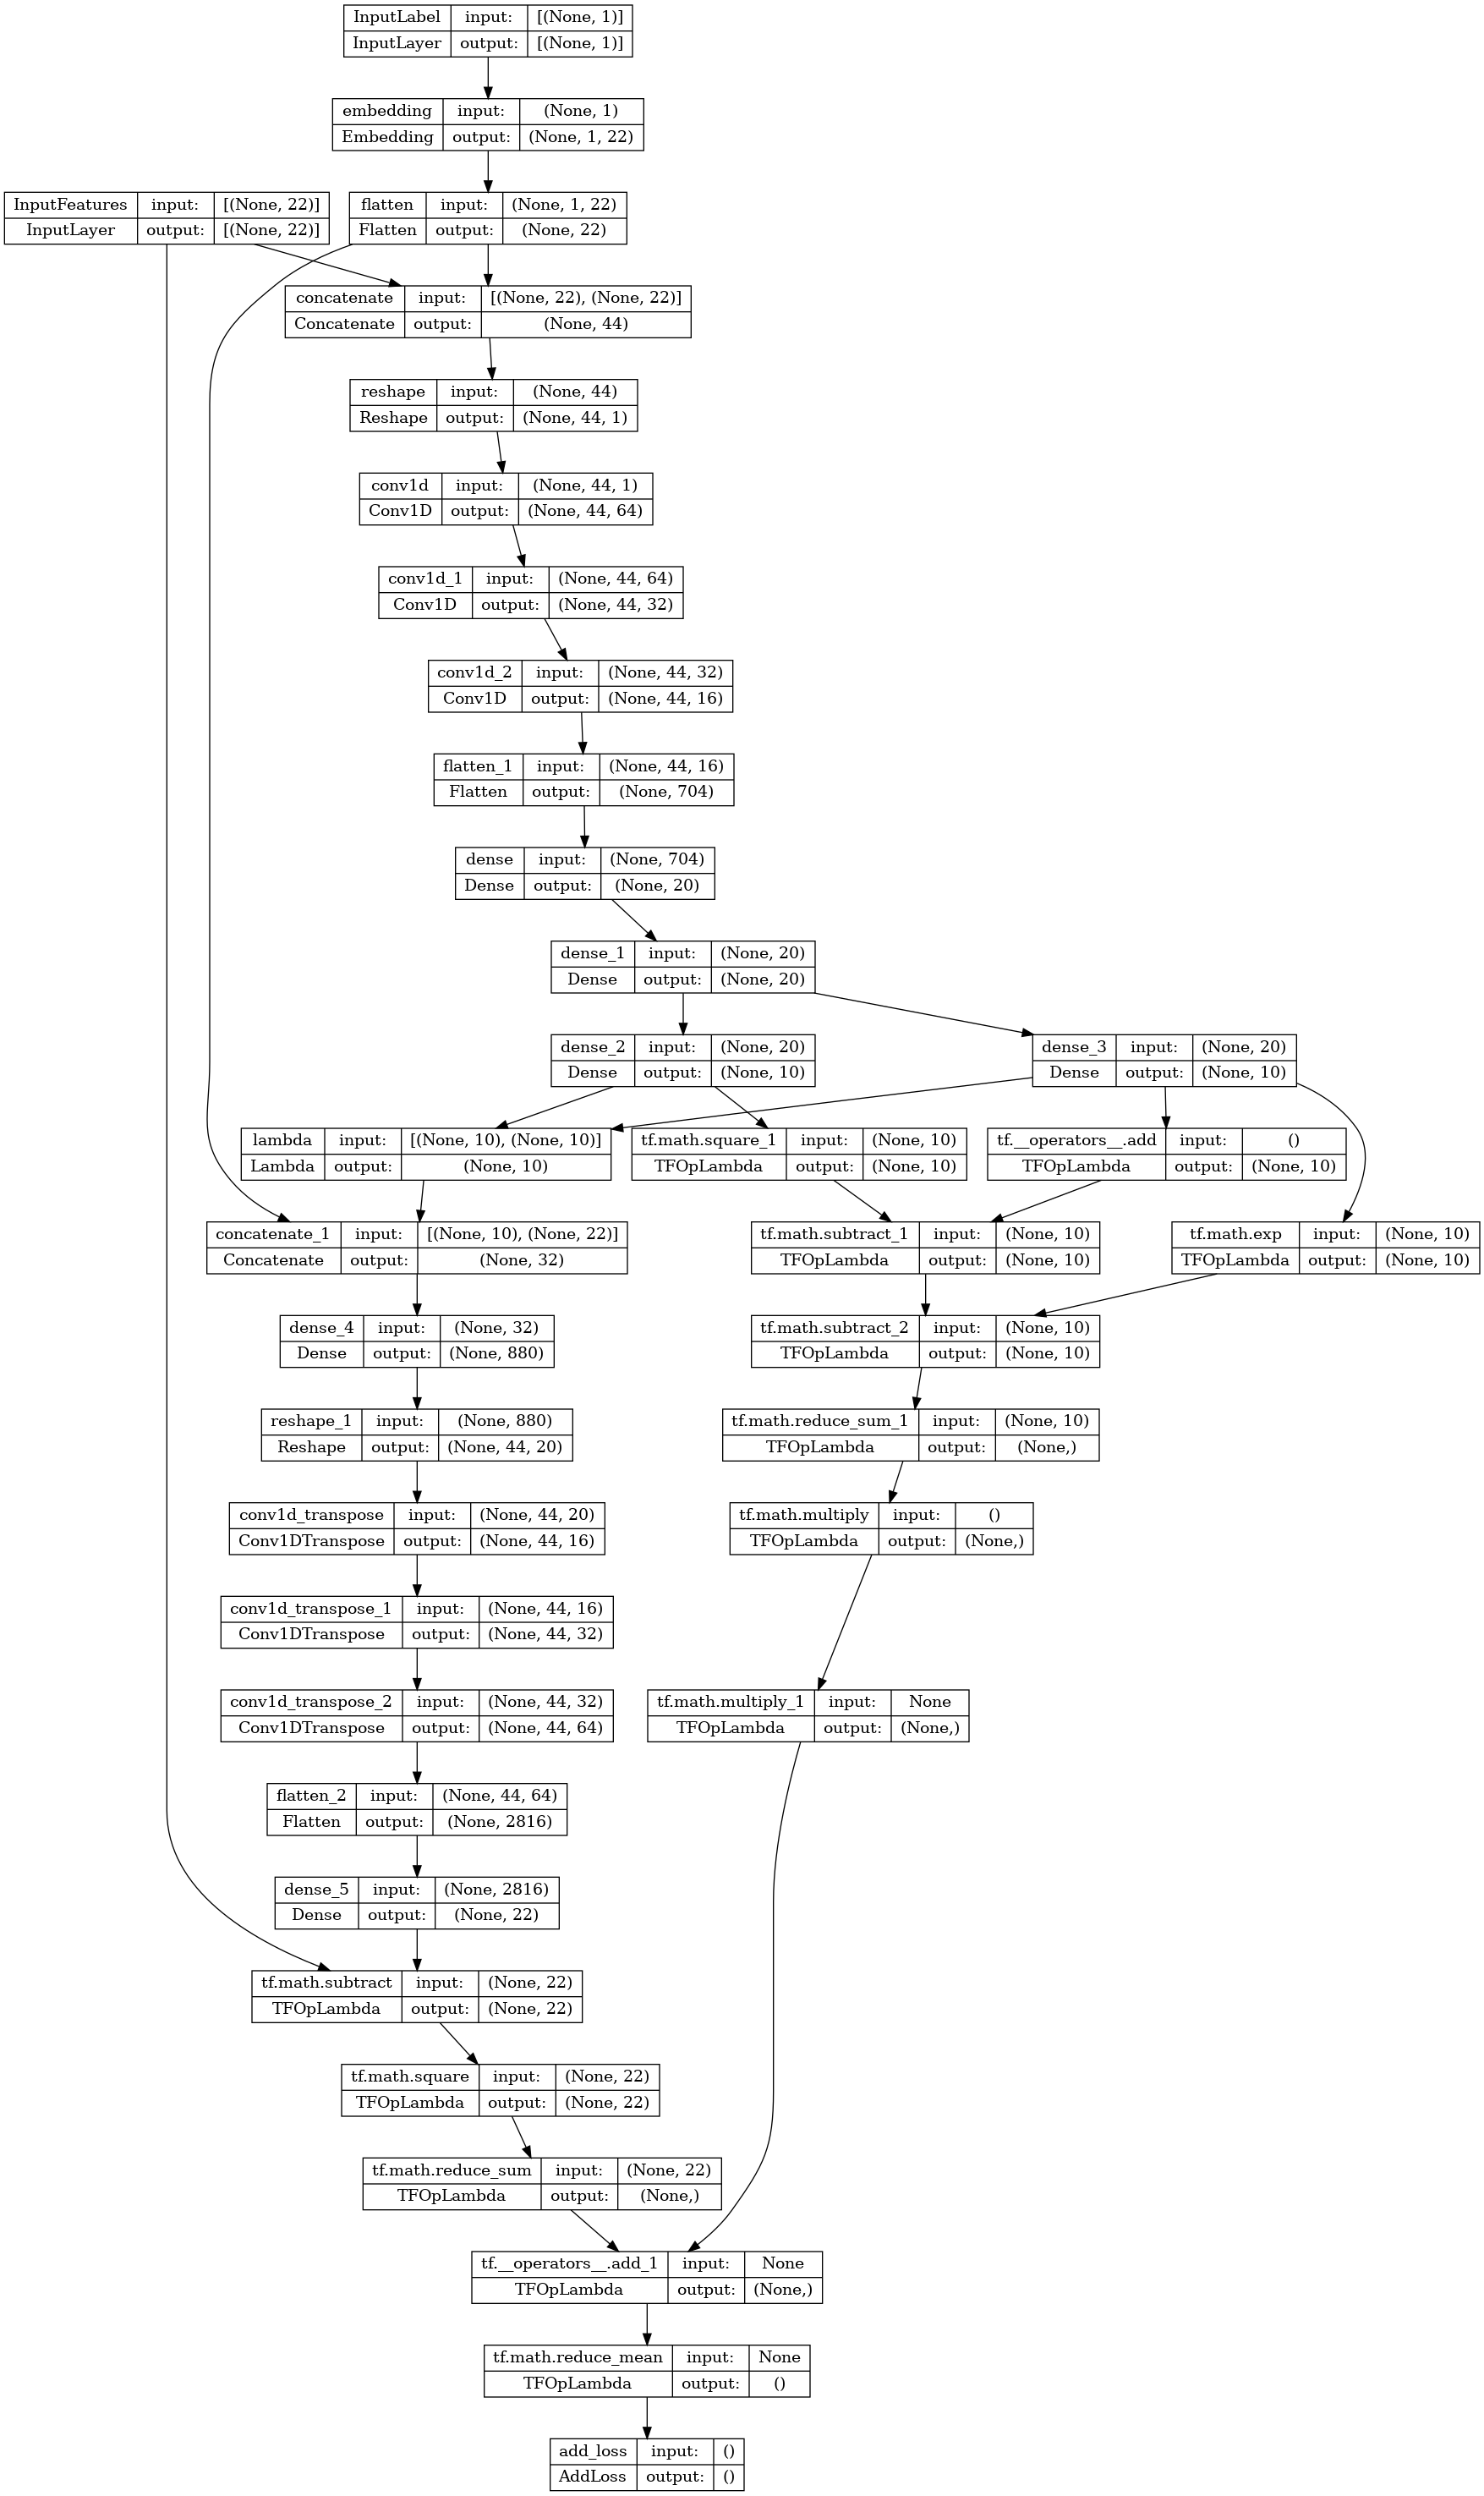

In [53]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

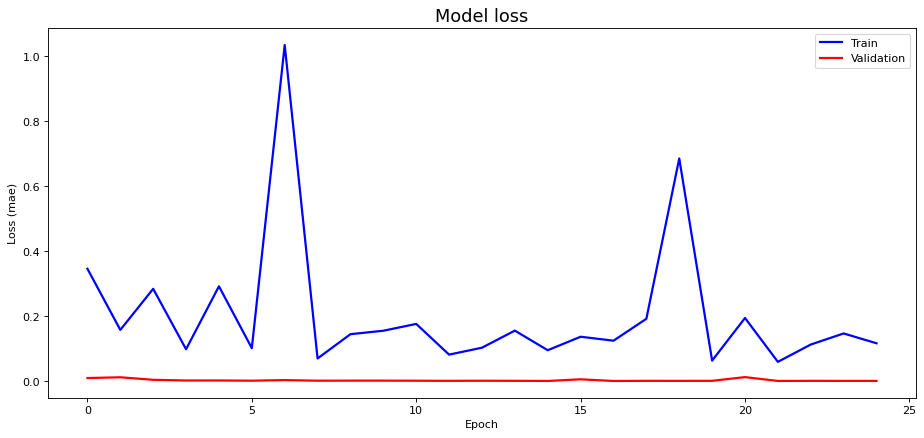

In [54]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [55]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [56]:
valid_x_predictions = model.predict([X_test, y_test])
#mse = np.mean(np.power(flatten(test_X_selected) - flatten(valid_x_predictions), 2), axis=1)

mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.tolist()})

8053/8053 [==============================] - 15s 2ms/step


In [57]:
error_df

reconstruction_error  true_class
0                   0.233848           0
1                   0.303193           0
2                   0.171713           0
3                   3.668321           0
4                   0.189261           0
...                      ...         ...
257668              0.135200           0
257669              0.442608           0
257670              0.362840           0
257671              0.343919           0
257672              0.144931           0

[257673 rows x 2 columns]

In [58]:
error_df[error_df['true_class']==0]

reconstruction_error  true_class
0                   0.233848           0
1                   0.303193           0
2                   0.171713           0
3                   3.668321           0
4                   0.189261           0
...                      ...         ...
257668              0.135200           0
257669              0.442608           0
257670              0.362840           0
257671              0.343919           0
257672              0.144931           0

[93000 rows x 2 columns]

/tmp/ipykernel_169/349485020.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


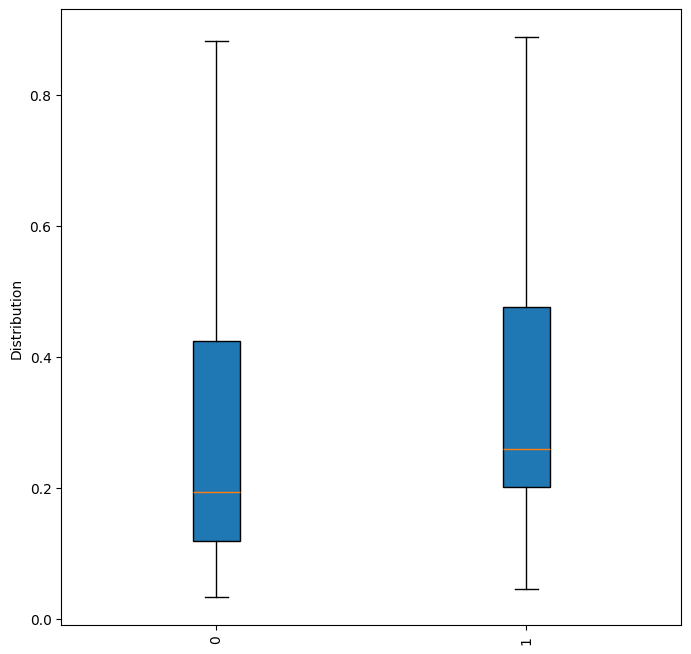

In [59]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


Best threshold: 0.13
Best F1 score: 0.8200460320143558


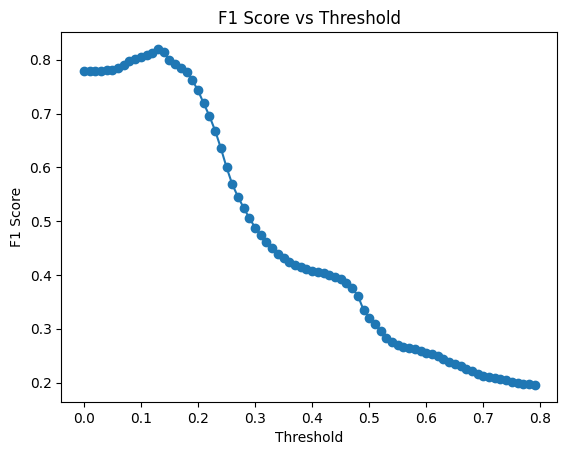

In [60]:


import numpy as np
from sklearn.metrics import f1_score

# Define the range of threshold values
threshold_range = np.arange(0, 0.8, 0.01)

# List to store F1 scores for each threshold
f1_scores = []

# Loop through each threshold and calculate F1 score
for threshold in threshold_range:
    y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
    f1 = f1_score(error_df.true_class, y_pred)
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
best_threshold = threshold_range[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {best_f1_score}")

# Optionally, you can plot the F1 scores across the threshold range
plt.plot(threshold_range, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()


In [61]:
# 그래프 보고 threshold 결정 0.35
threshold = 0.13

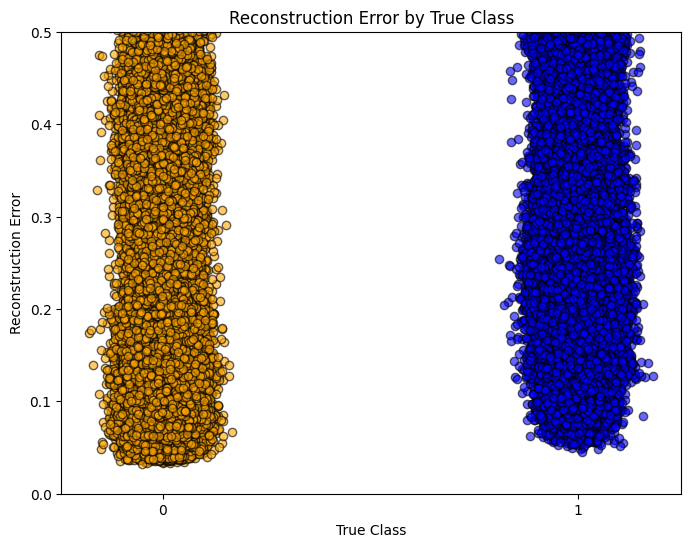

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes with a specified y-axis limit
plt.figure(figsize=(8, 6))

# Add jitter to avoid overlapping points in the scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Jitter for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Jitter for class 1

# Create the scatter plot
plt.scatter(x_0, true_class_0, color='orange', alpha=0.6, edgecolor='black', label='Class 0')
plt.scatter(x_1, true_class_1, color='blue', alpha=0.6, edgecolor='black', label='Class 1')

# Set y-axis limit
plt.ylim(0, 0.5)

# Set x-axis labels and adjust ticks
plt.xticks([1, 2], ['0', '1'])
plt.xlabel('True Class')

# Set y-axis label and title
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by True Class')

# Display the plot
plt.show()


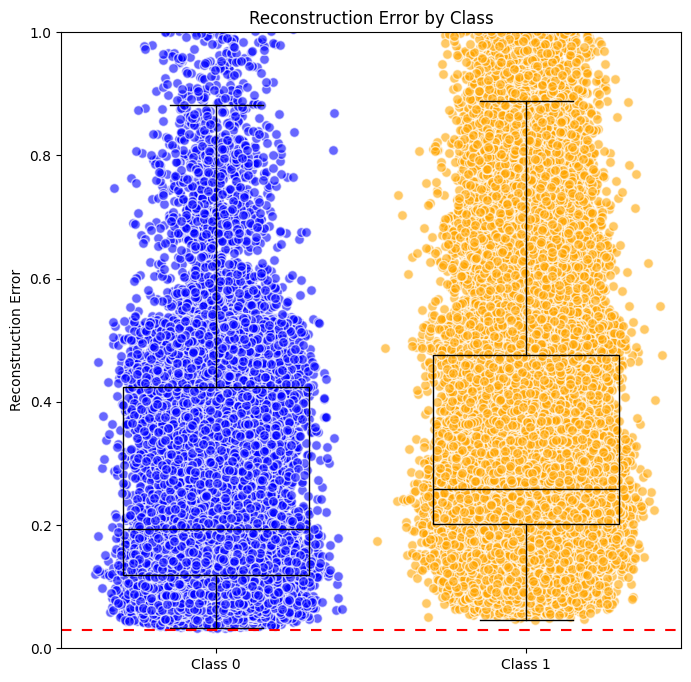

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create a swarm plot equivalent using scatter plot with more jitter
x_0 = np.random.normal(1, 0.1, size=len(true_class_0))  # Increased jitter for class 0
x_1 = np.random.normal(2, 0.1, size=len(true_class_1))  # Increased jitter for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showfliers=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black'))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
ax.axhline(y=0.03, xmin=0.0, xmax=1, dashes=(5, 5), color='red')

# Adjust y-axis limit to make sure the threshold line is visible
#ax.set_ylim(bottom=min(min(true_class_0), min(true_class_1)) - 0.01, 
#           top=max(max(true_class_0), max(true_class_1)) + 0.01)
ax.set_ylim(bottom=0, top=1)
    
# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


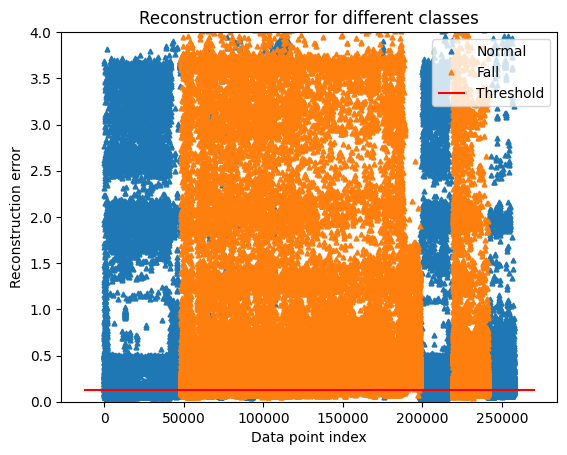

In [64]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim(0, 4)
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

<Figure size 1200x1200 with 0 Axes>

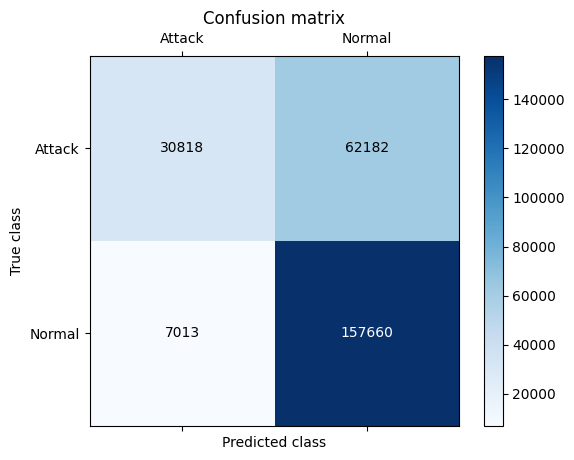

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined LABELS, threshold, and y_pred

LABELS = ["Attack", "Normal"]

y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# Create the figure and axis
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# Plot the confusion matrix using imshow
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set the labels for the axes
ax.set_xticks(np.arange(len(LABELS)))
ax.set_yticks(np.arange(len(LABELS)))

ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)

# Set labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# Annotate the confusion matrix with the counts
for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()


In [66]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.7314619692400833
Precision : 0.7171514087390035
Recall : 0.9574125691521986
F1 : 0.8200460320143558


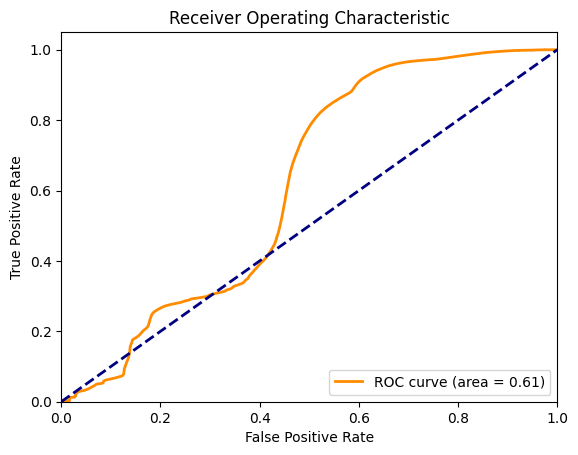

In [67]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and reconstruction_error have been defined
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


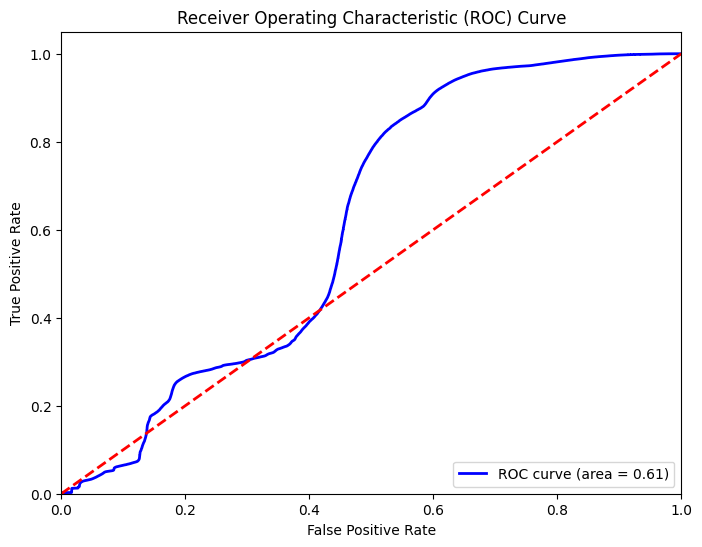

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the true labels and reconstruction errors from error_df
y_true = error_df['true_class']
y_scores = error_df['reconstruction_error']

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()


In [69]:
print(f"ROC Score : {roc_auc}")

ROC Score : 0.6146384566376545


In [70]:
# If error_df.true_class is a nested structure, flatten it
y_test = error_df.true_class.apply(lambda x: int(x[0][0]) if isinstance(x, list) else int(x))

# Ensure y_pred is a list of integers
y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]

# Now calculate the metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy Score: 0.7314619692400833
Precision: 0.7171514087390035
Recall: 0.9574125691521986
F1 Score: 0.8200460320143558


/tmp/ipykernel_169/2396438607.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(reconstruction_error, label="Train Error", shade=True)


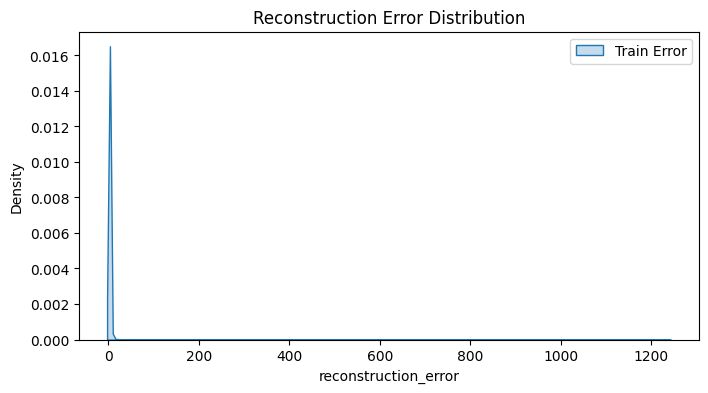

In [71]:
plt.figure(figsize=(8, 4))
sns.kdeplot(reconstruction_error, label="Train Error", shade=True)
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()


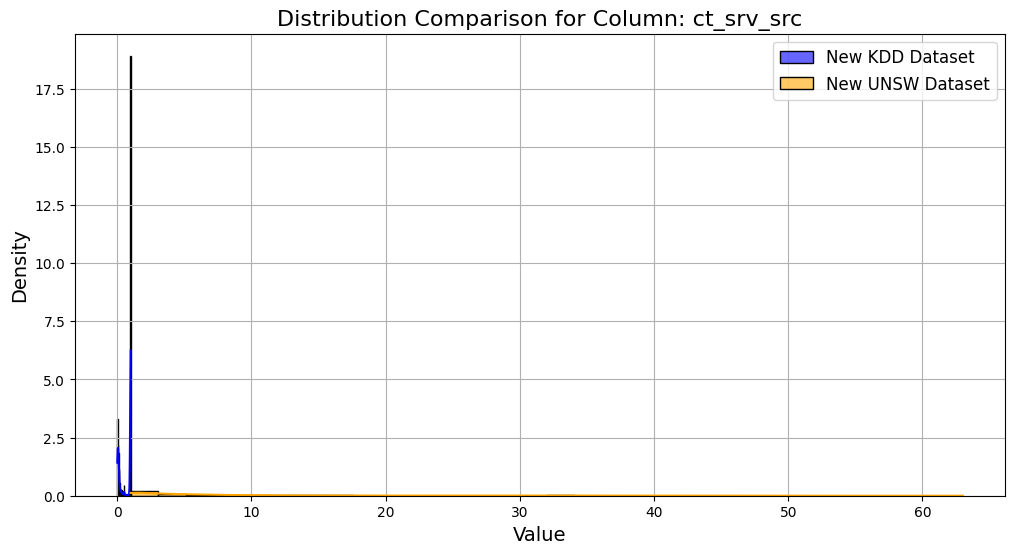

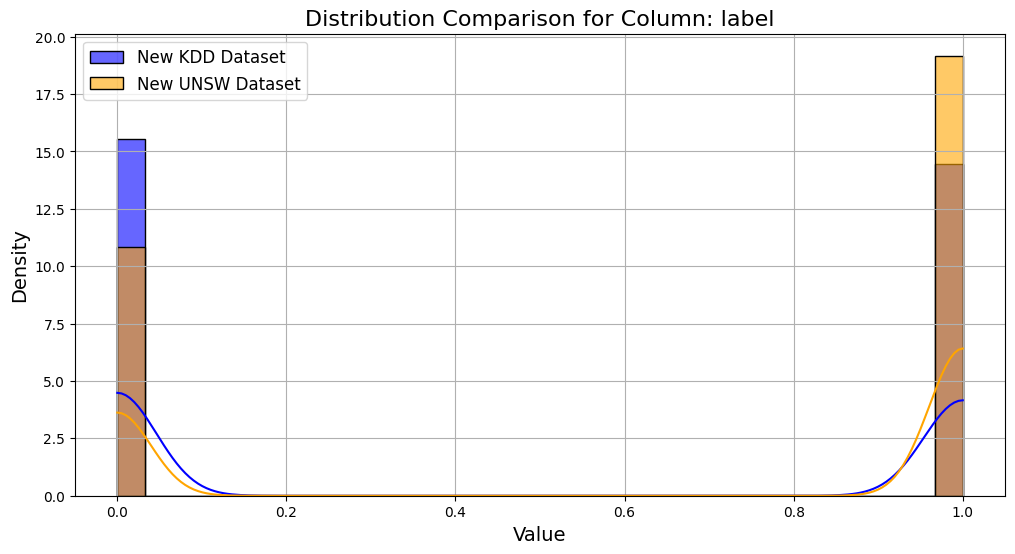

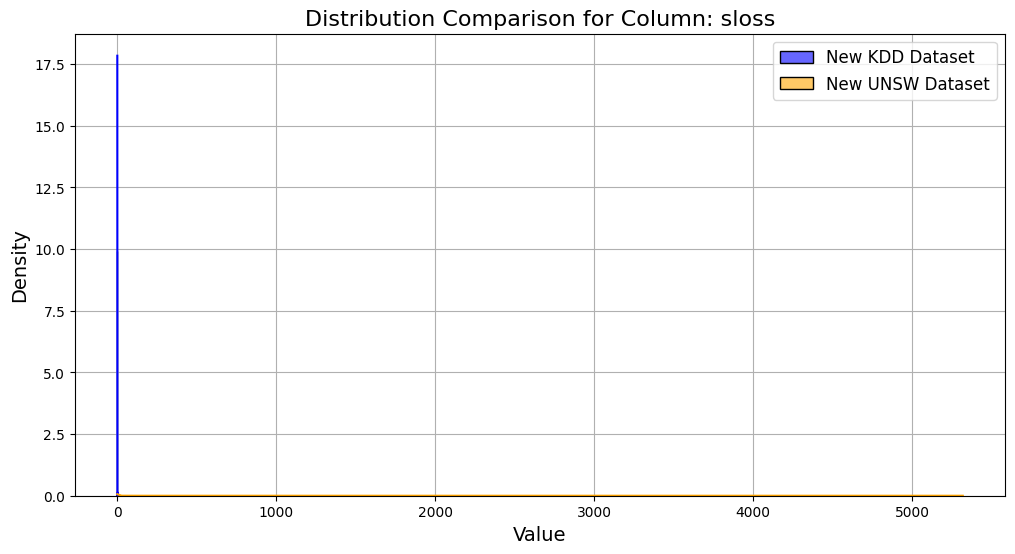

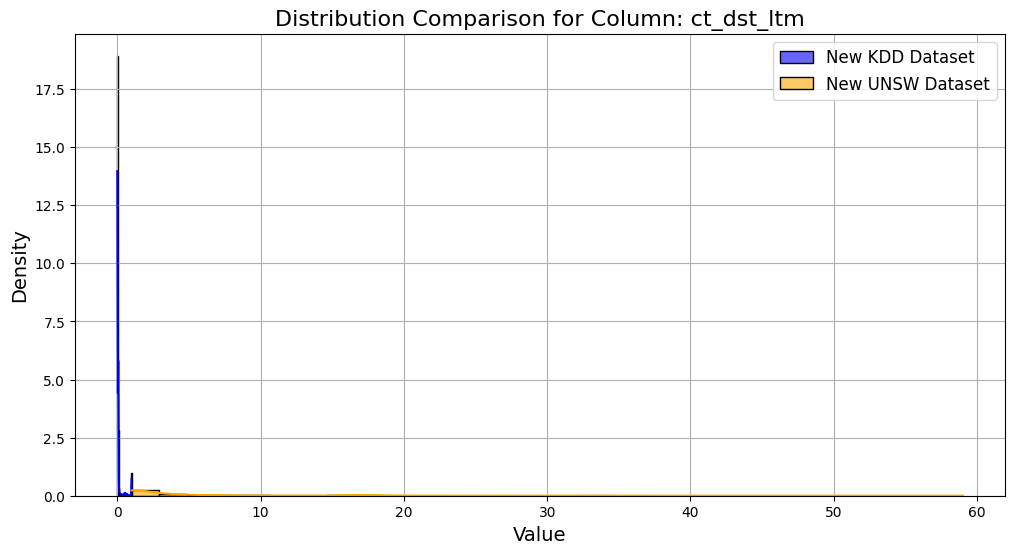

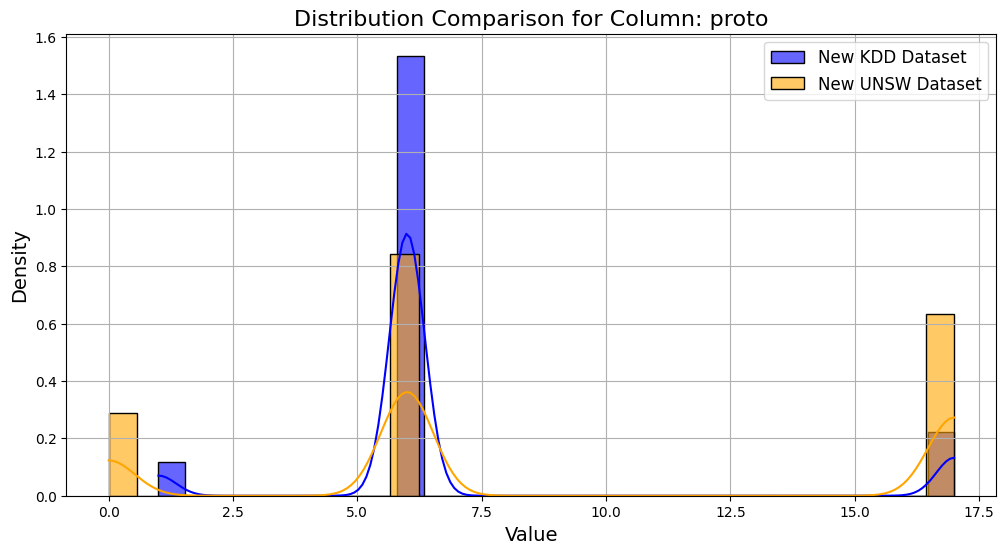

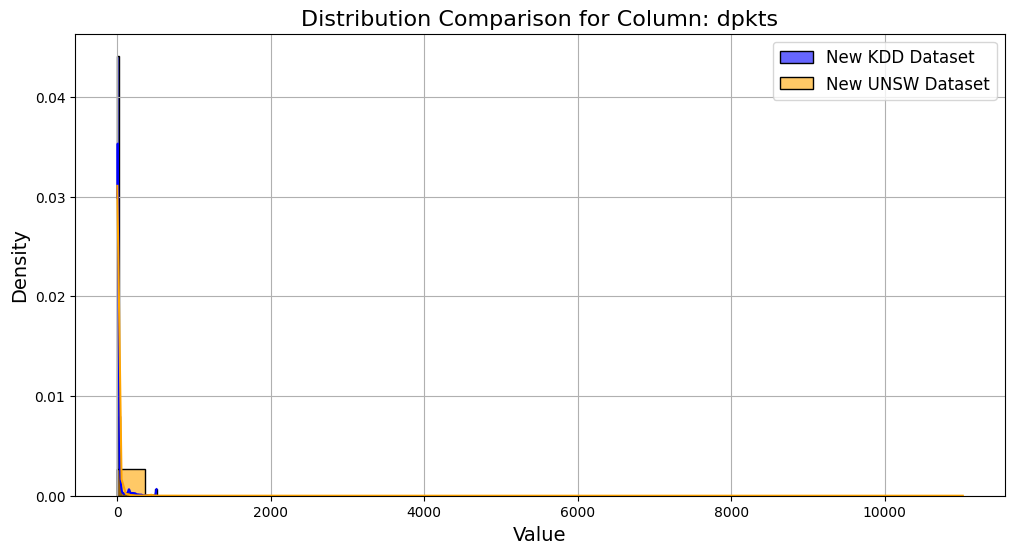

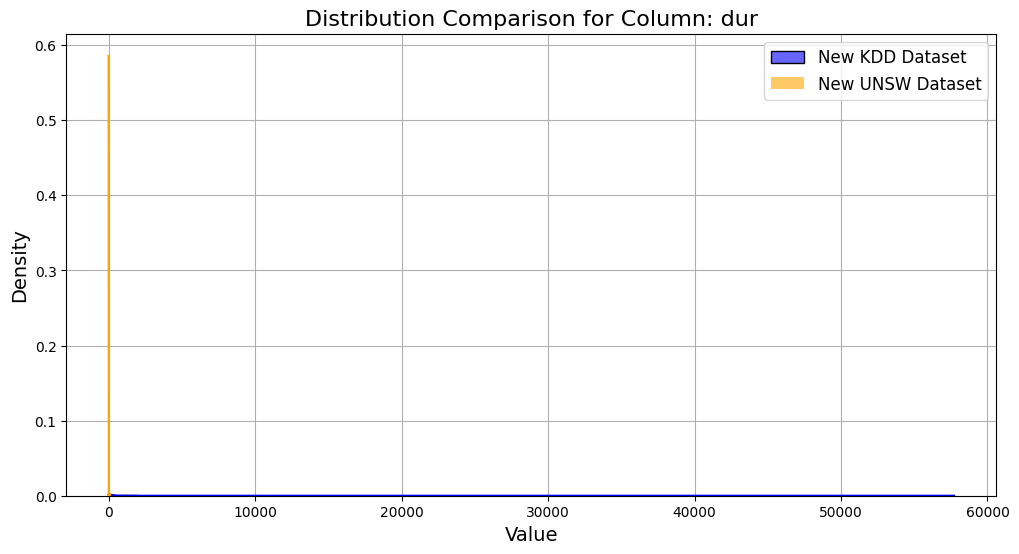

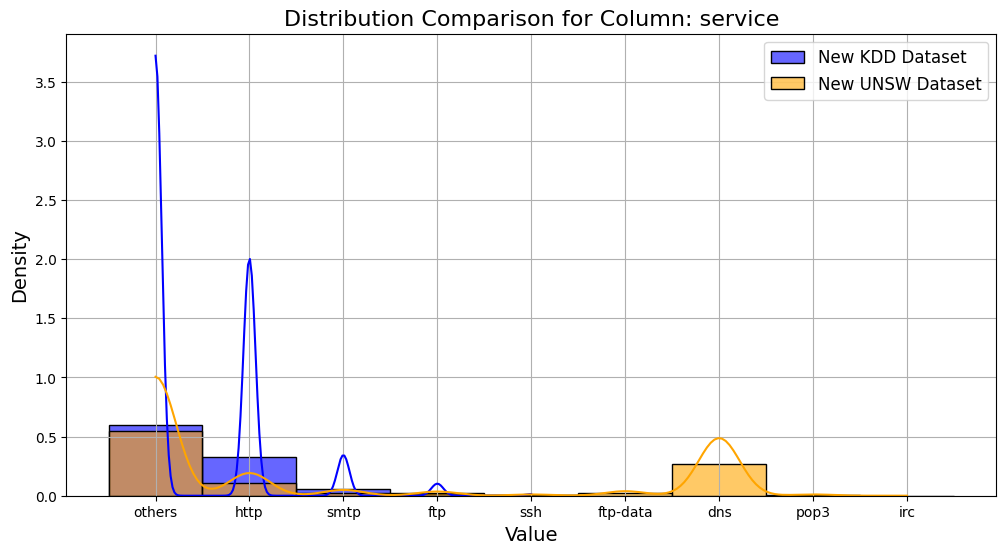

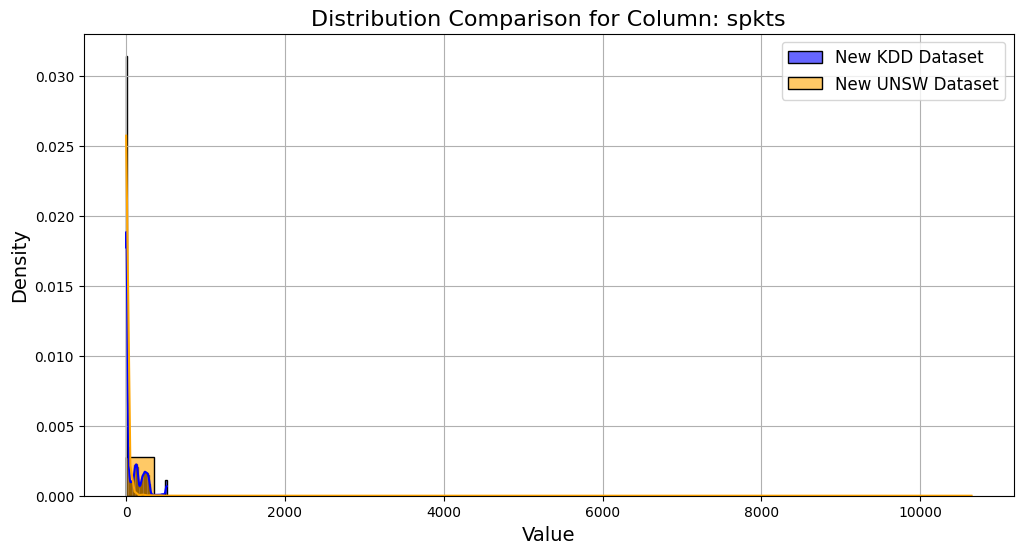

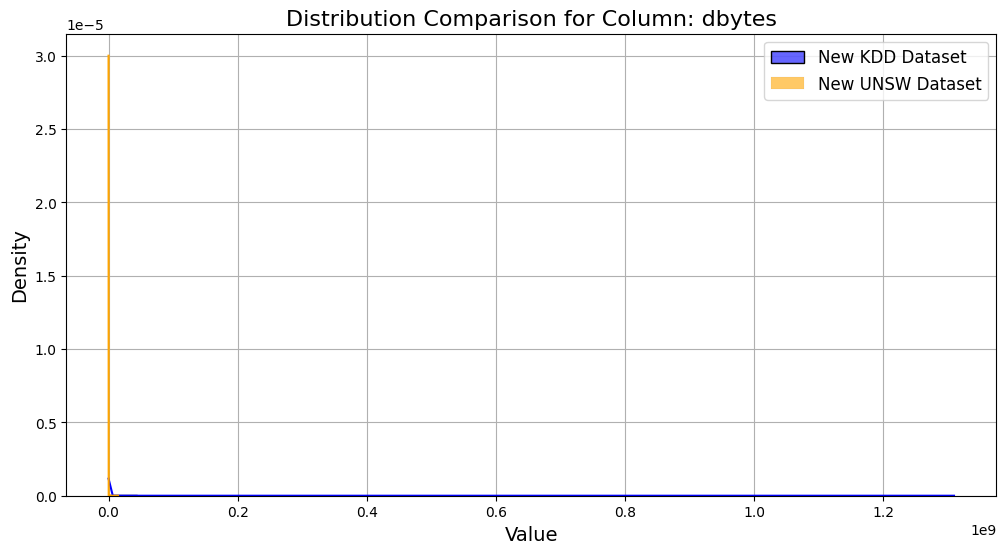

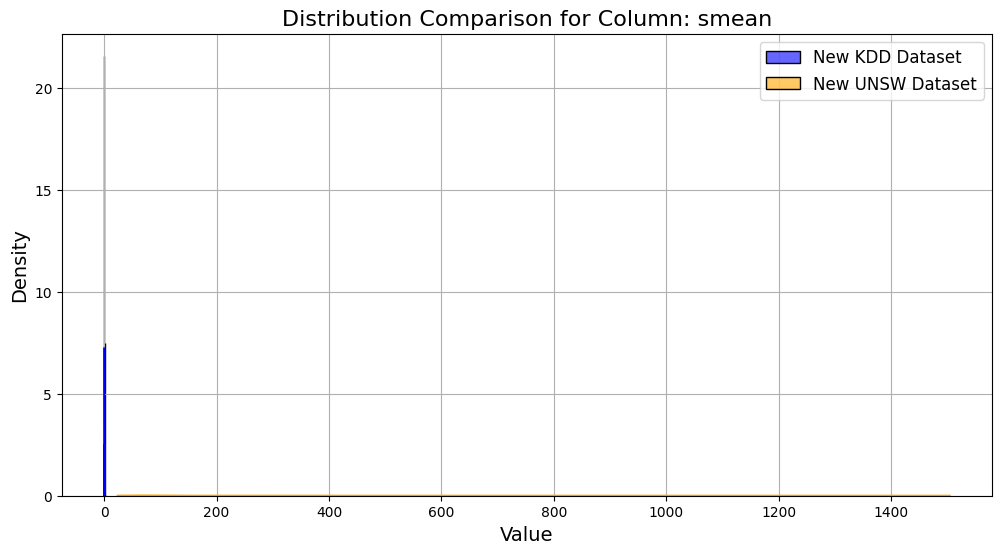

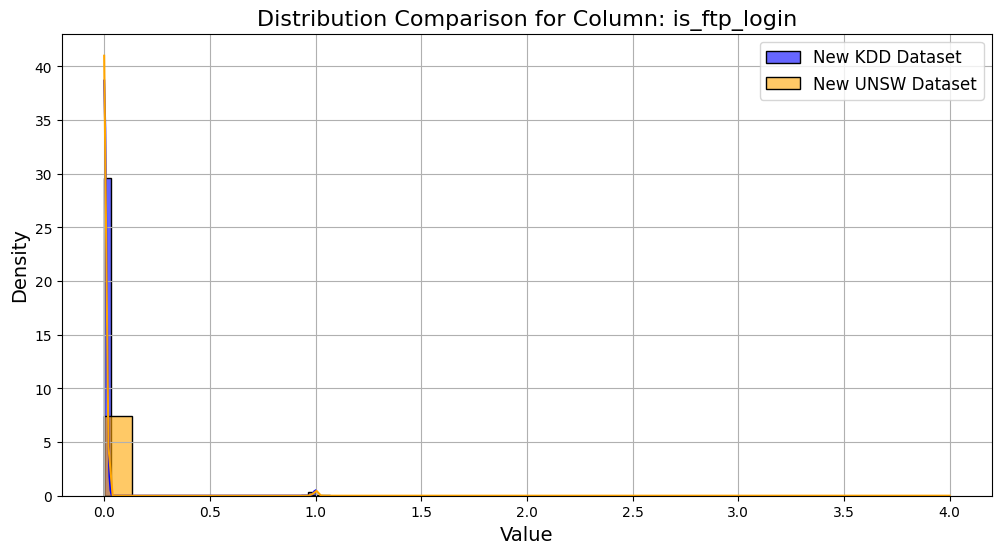

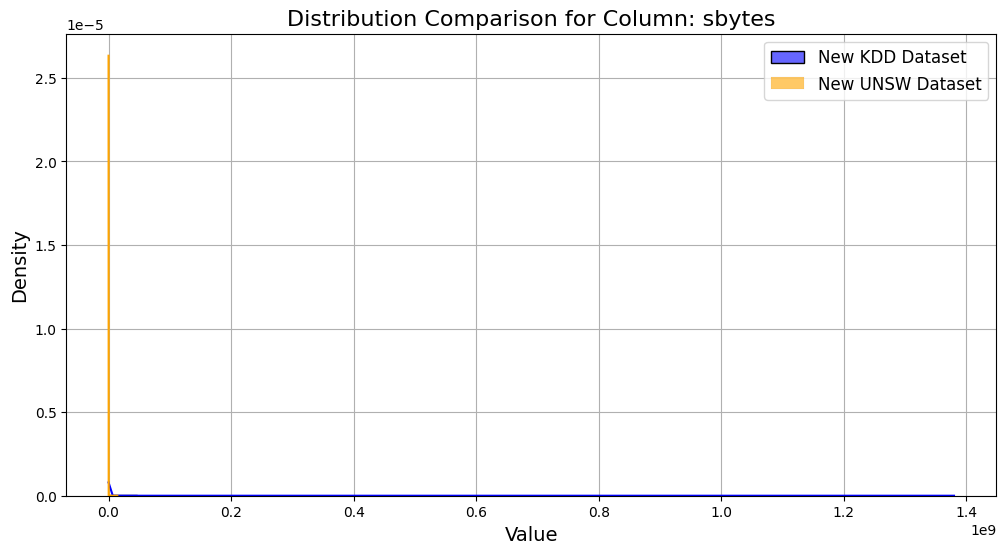

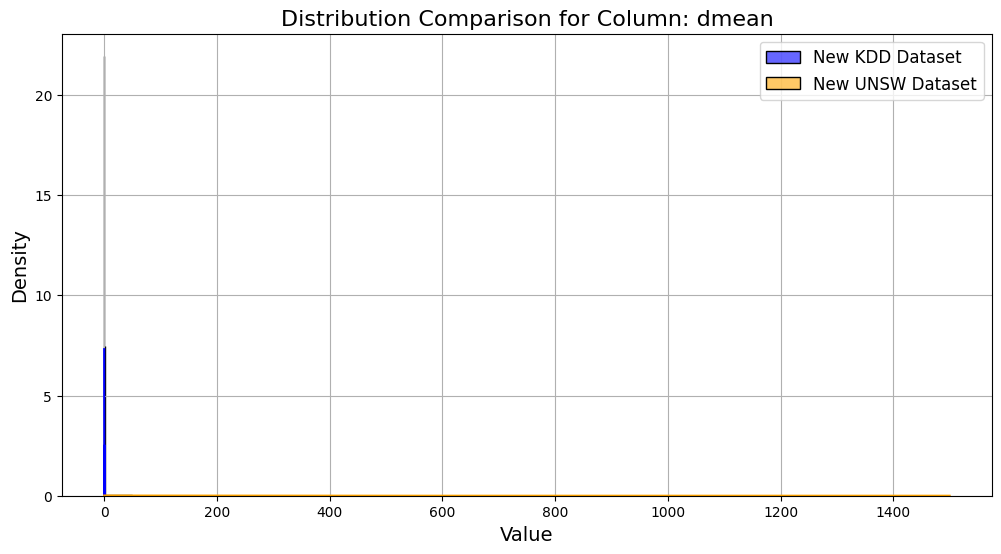

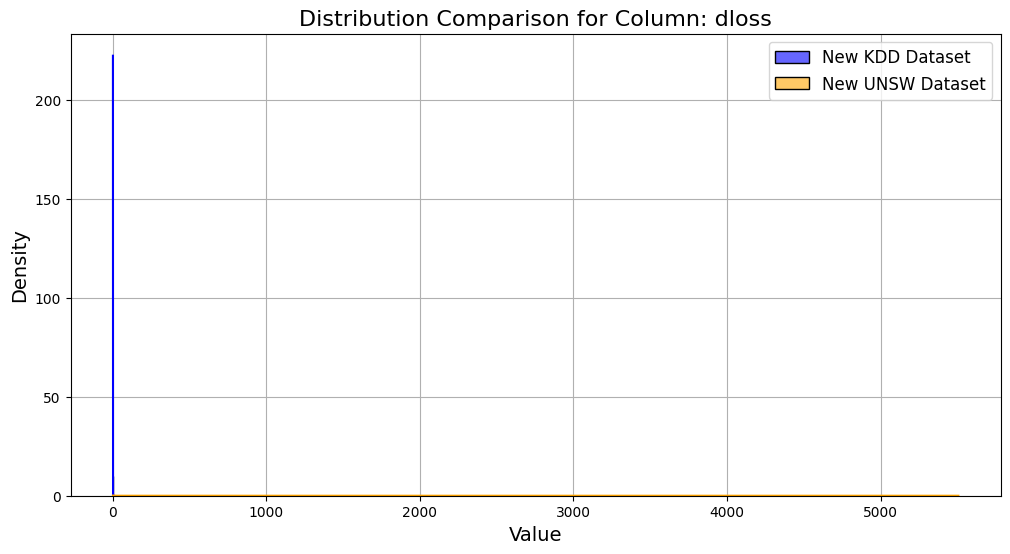

In [73]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 데이터셋 분포 비교 코드
import matplotlib.pyplot as plt
import seaborn as sns

# 공통 컬럼 가져오기
common_columns = set(new_kdd_df.columns).intersection(new_unsw_df.columns)

# 출력 제한 해제
from IPython.display import display
pd.options.display.max_columns = None  # 컬럼 출력 제한 해제
pd.options.display.max_rows = None  # 행 출력 제한 해제

# 각 컬럼별 분포 시각화
for column in common_columns:
    plt.figure(figsize=(12, 6))

    # new_kdd_df 분포
    sns.histplot(new_kdd_df[column], kde=True, color='blue', label='New KDD Dataset', stat='density', bins=30, alpha=0.6)

    # new_unsw_df 분포
    sns.histplot(new_unsw_df[column], kde=True, color='orange', label='New UNSW Dataset', stat='density', bins=30, alpha=0.6)

    # 그래프 꾸미기
    plt.title(f'Distribution Comparison for Column: {column}', fontsize=16)
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='ct_srv_src', ylabel='Density'>

<Axes: xlabel='ct_srv_src', ylabel='Density'>

<Axes: xlabel='ct_srv_src', ylabel='Density'>

<Axes: xlabel='ct_srv_src', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: ct_srv_src (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

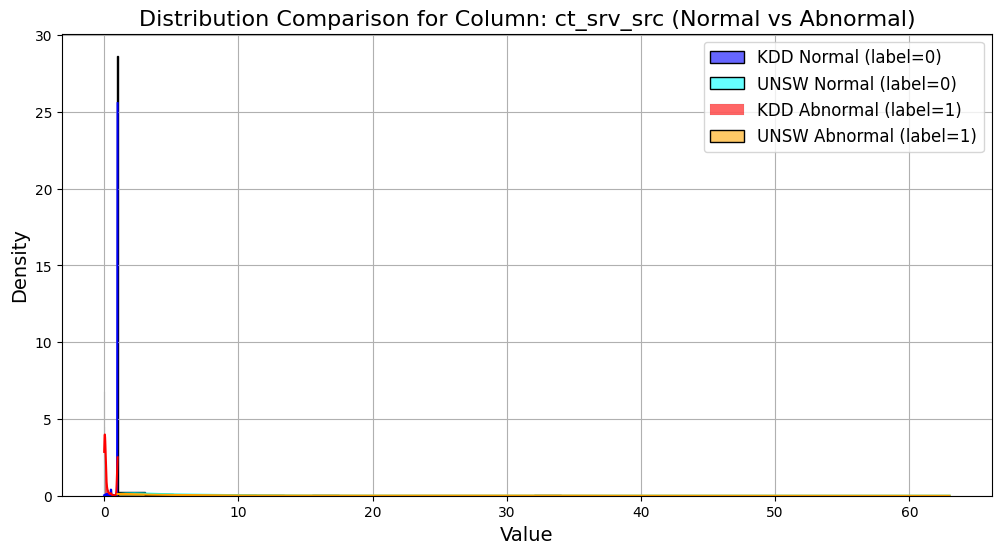

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='sloss', ylabel='Density'>

<Axes: xlabel='sloss', ylabel='Density'>

<Axes: xlabel='sloss', ylabel='Density'>

<Axes: xlabel='sloss', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: sloss (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

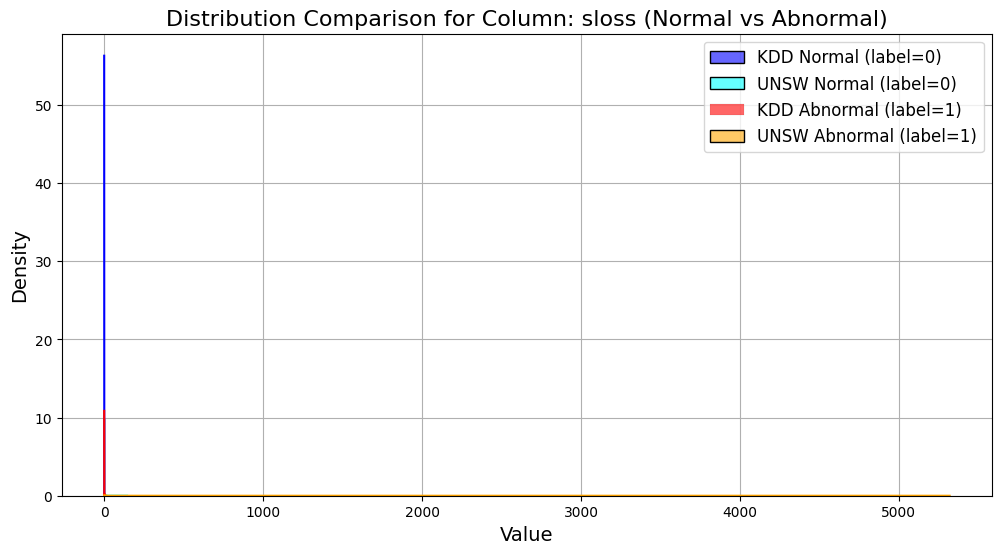

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='ct_dst_ltm', ylabel='Density'>

<Axes: xlabel='ct_dst_ltm', ylabel='Density'>

<Axes: xlabel='ct_dst_ltm', ylabel='Density'>

<Axes: xlabel='ct_dst_ltm', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: ct_dst_ltm (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

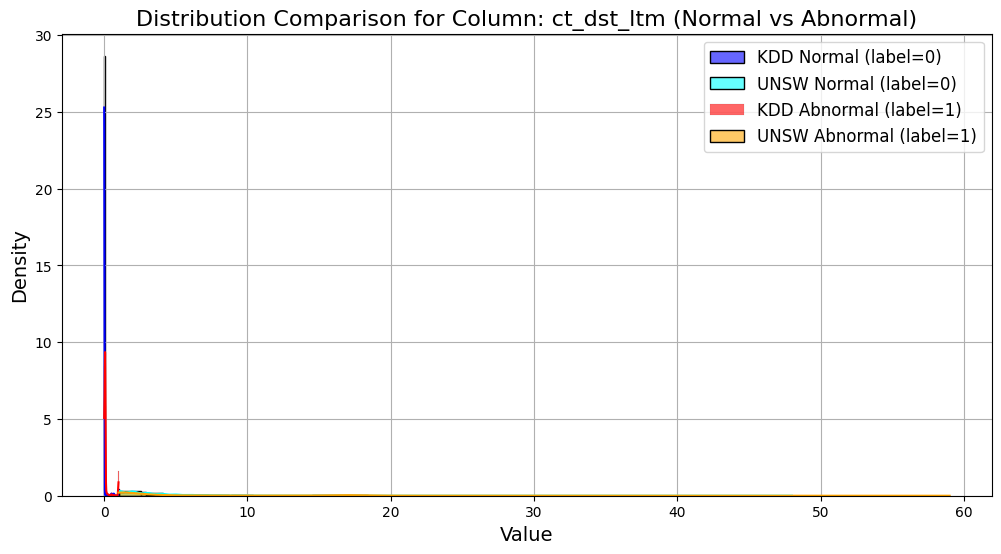

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='proto', ylabel='Density'>

<Axes: xlabel='proto', ylabel='Density'>

<Axes: xlabel='proto', ylabel='Density'>

<Axes: xlabel='proto', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: proto (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

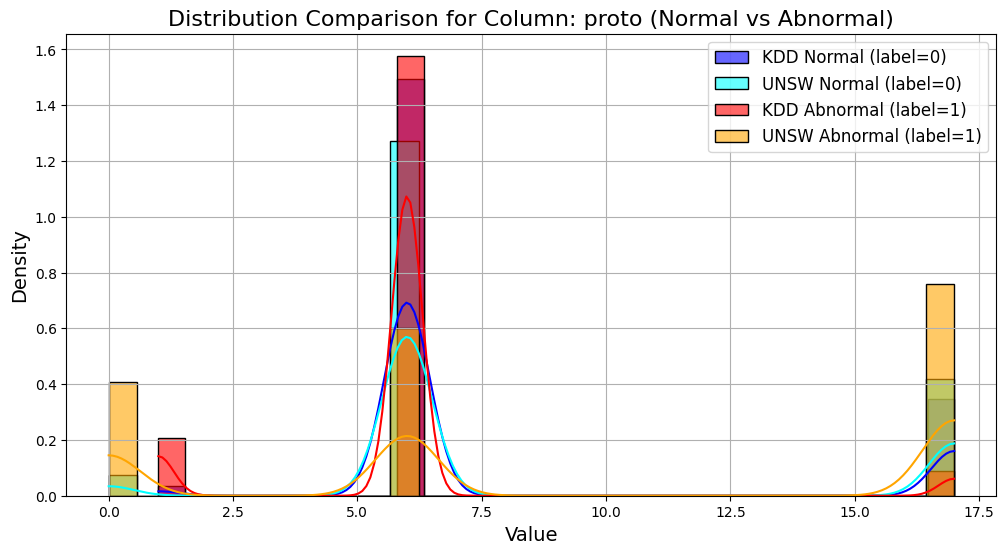

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='dpkts', ylabel='Density'>

<Axes: xlabel='dpkts', ylabel='Density'>

<Axes: xlabel='dpkts', ylabel='Density'>

<Axes: xlabel='dpkts', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: dpkts (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

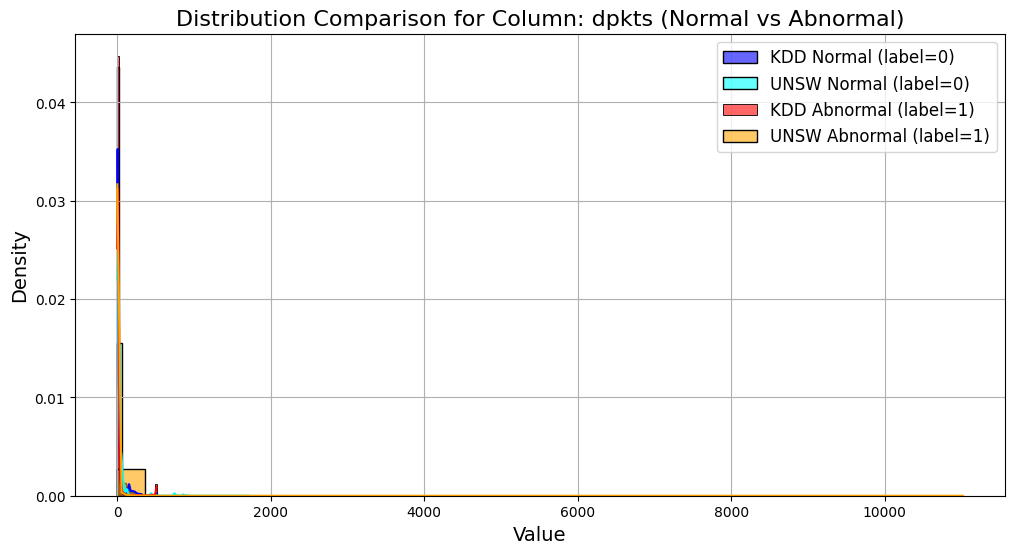

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='dur', ylabel='Density'>

<Axes: xlabel='dur', ylabel='Density'>

<Axes: xlabel='dur', ylabel='Density'>

<Axes: xlabel='dur', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: dur (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

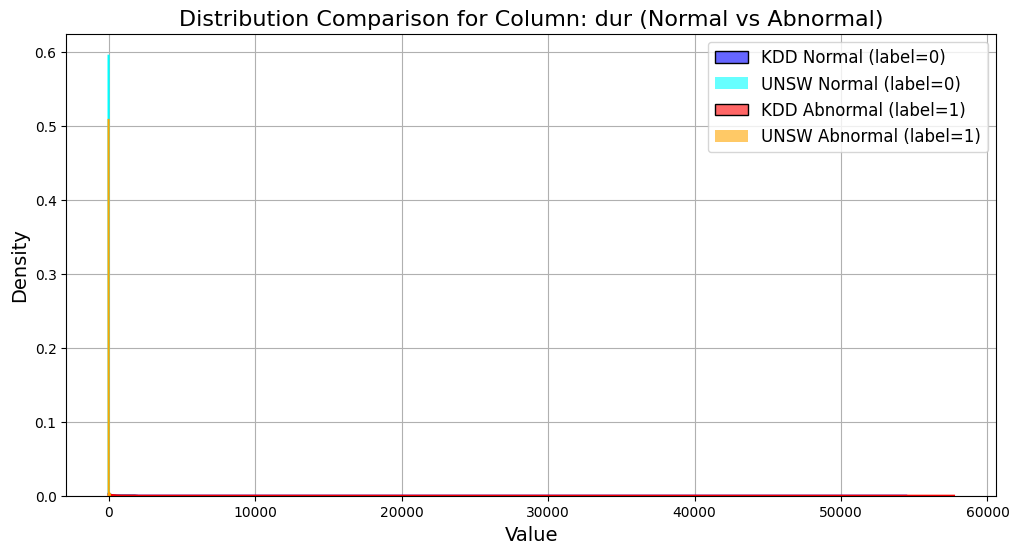

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='service', ylabel='Density'>

<Axes: xlabel='service', ylabel='Density'>

<Axes: xlabel='service', ylabel='Density'>

<Axes: xlabel='service', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: service (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

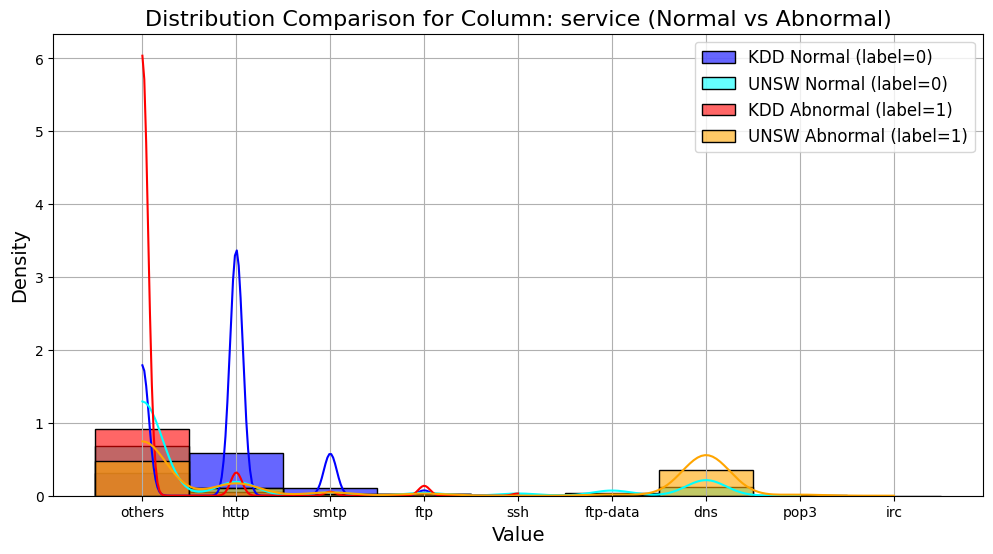

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='spkts', ylabel='Density'>

<Axes: xlabel='spkts', ylabel='Density'>

<Axes: xlabel='spkts', ylabel='Density'>

<Axes: xlabel='spkts', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: spkts (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

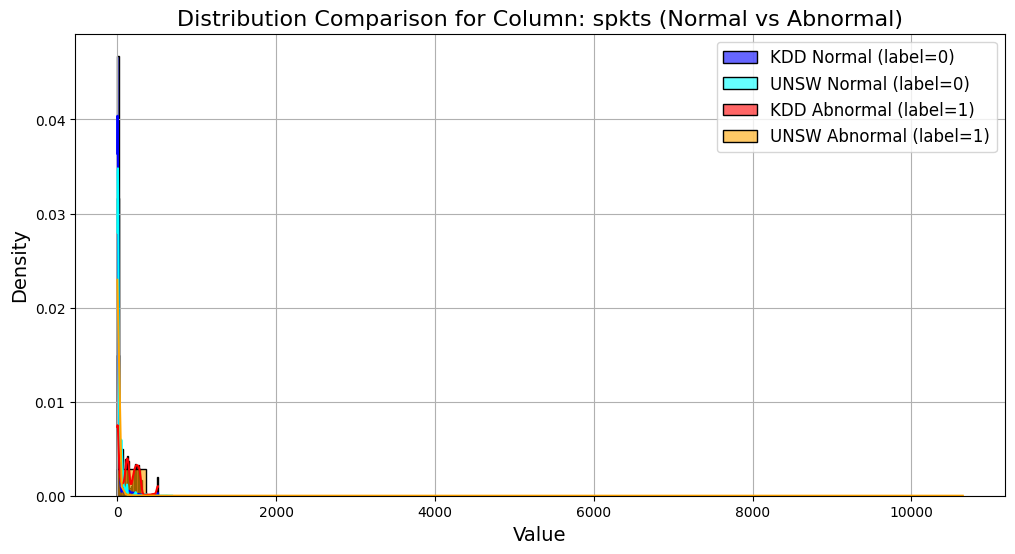

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='dbytes', ylabel='Density'>

<Axes: xlabel='dbytes', ylabel='Density'>

<Axes: xlabel='dbytes', ylabel='Density'>

<Axes: xlabel='dbytes', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: dbytes (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

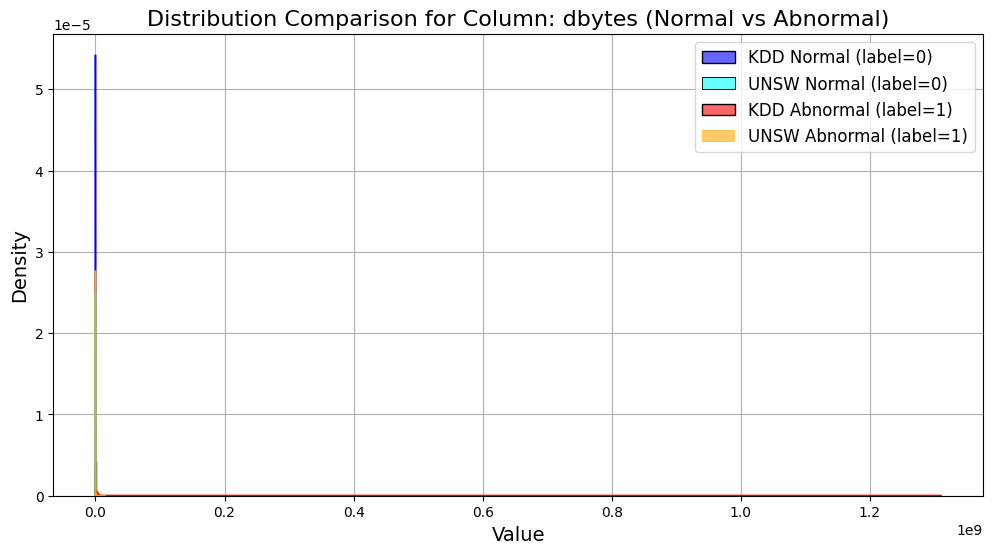

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='smean', ylabel='Density'>

<Axes: xlabel='smean', ylabel='Density'>

<Axes: xlabel='smean', ylabel='Density'>

<Axes: xlabel='smean', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: smean (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

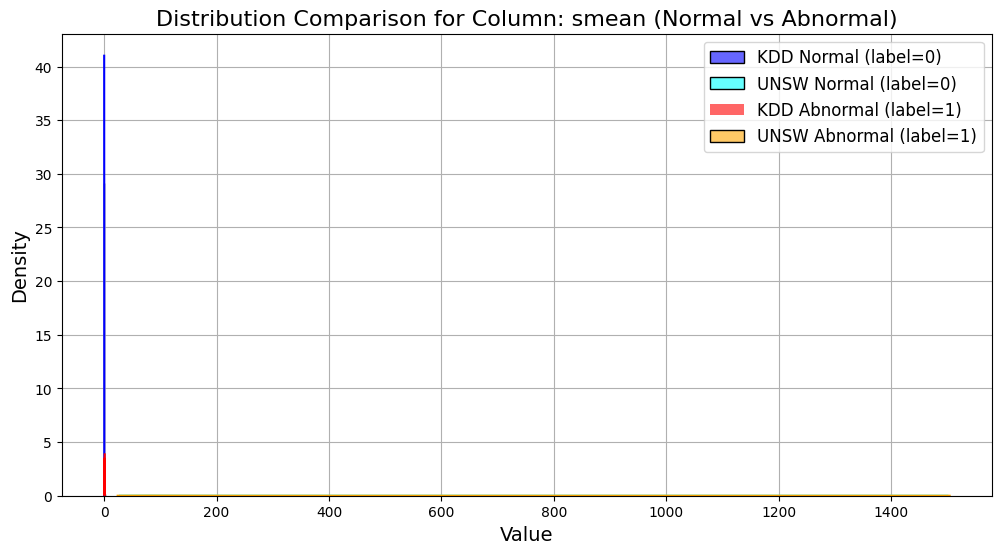

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='is_ftp_login', ylabel='Density'>

<Axes: xlabel='is_ftp_login', ylabel='Density'>

<Axes: xlabel='is_ftp_login', ylabel='Density'>

<Axes: xlabel='is_ftp_login', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: is_ftp_login (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

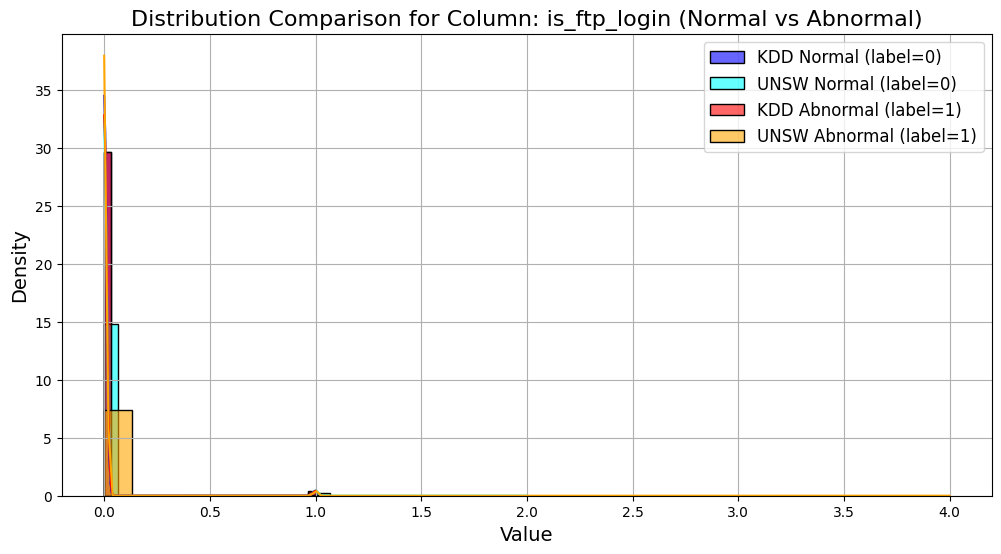

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='sbytes', ylabel='Density'>

<Axes: xlabel='sbytes', ylabel='Density'>

<Axes: xlabel='sbytes', ylabel='Density'>

<Axes: xlabel='sbytes', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: sbytes (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

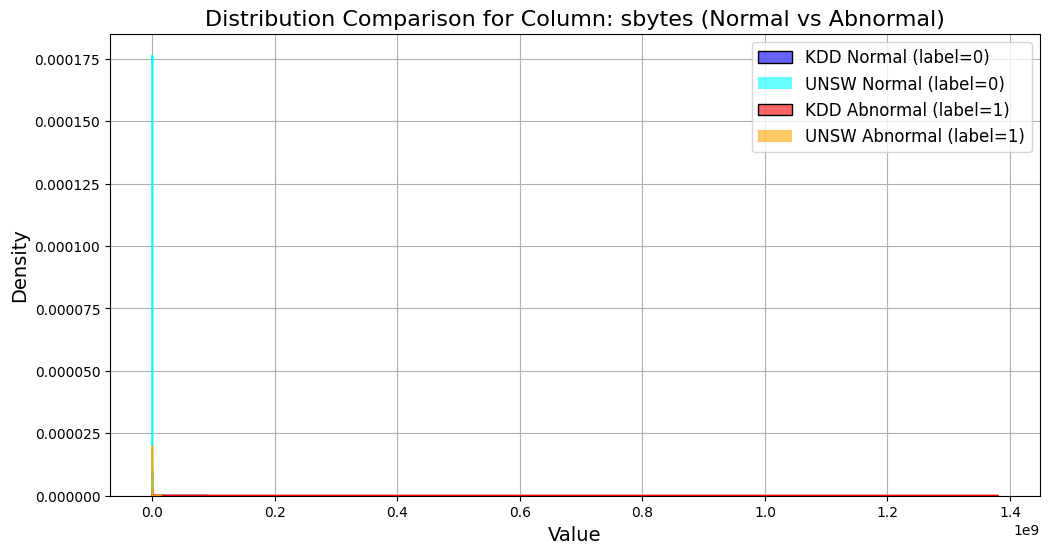

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='dmean', ylabel='Density'>

<Axes: xlabel='dmean', ylabel='Density'>

<Axes: xlabel='dmean', ylabel='Density'>

<Axes: xlabel='dmean', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: dmean (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

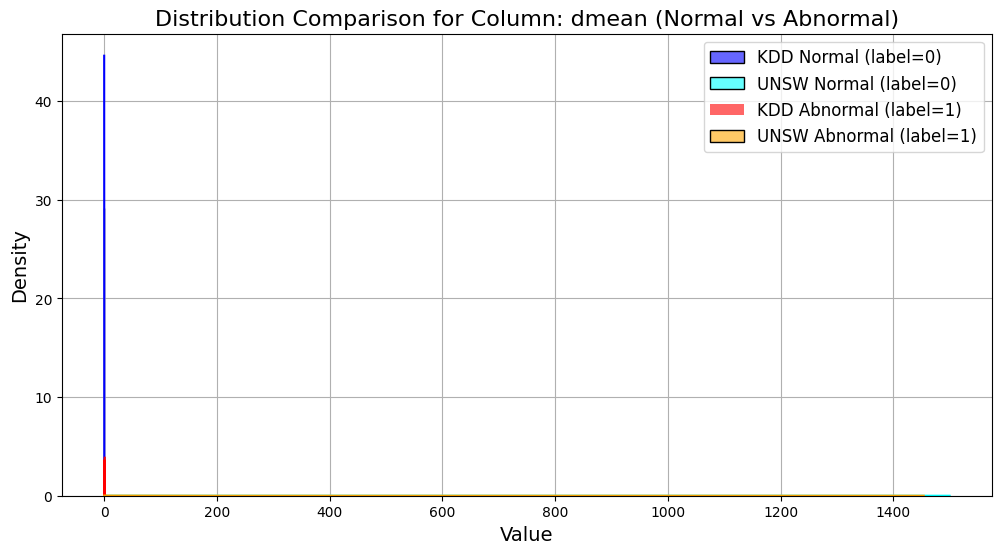

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='dloss', ylabel='Density'>

<Axes: xlabel='dloss', ylabel='Density'>

<Axes: xlabel='dloss', ylabel='Density'>

<Axes: xlabel='dloss', ylabel='Density'>

Text(0.5, 1.0, 'Distribution Comparison for Column: dloss (Normal vs Abnormal)')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

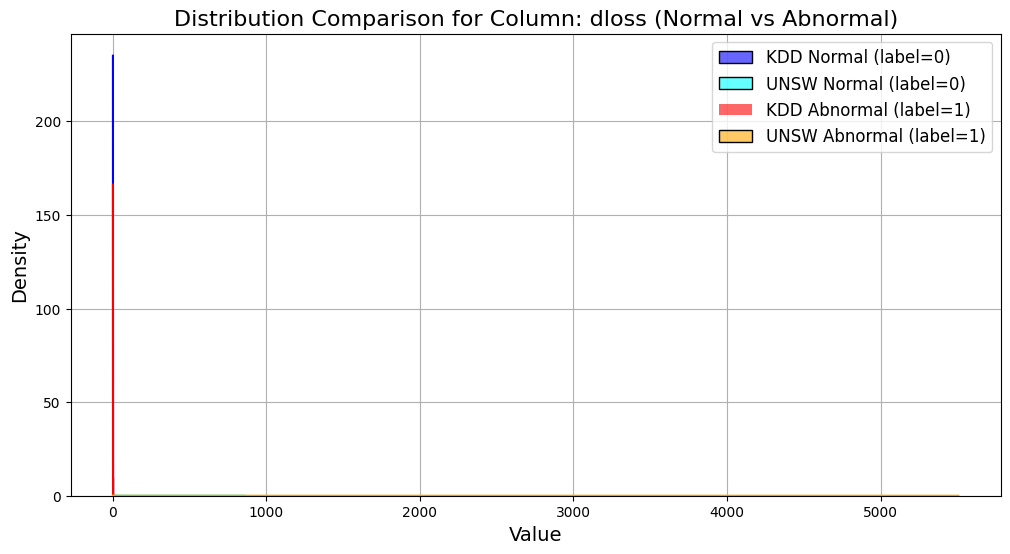

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# 정상 (label=0)과 비정상 (label=1) 데이터 분리
kdd_normal = new_kdd_df[new_kdd_df['label'] == 0]
kdd_abnormal = new_kdd_df[new_kdd_df['label'] == 1]
unsw_normal = new_unsw_df[new_unsw_df['label'] == 0]
unsw_abnormal = new_unsw_df[new_unsw_df['label'] == 1]

# 공통 컬럼 가져오기 (label 제외)
common_columns = set(new_kdd_df.columns).intersection(new_unsw_df.columns) - {'label'}

# 각 컬럼별로 정상과 비정상의 분포 시각화
for column in common_columns:
    plt.figure(figsize=(12, 6))

    # 정상 데이터 분포 (label=0)
    sns.histplot(kdd_normal[column], kde=True, color='blue', label='KDD Normal (label=0)', stat='density', bins=30, alpha=0.6)
    sns.histplot(unsw_normal[column], kde=True, color='cyan', label='UNSW Normal (label=0)', stat='density', bins=30, alpha=0.6)

    # 비정상 데이터 분포 (label=1)
    sns.histplot(kdd_abnormal[column], kde=True, color='red', label='KDD Abnormal (label=1)', stat='density', bins=30, alpha=0.6)
    sns.histplot(unsw_abnormal[column], kde=True, color='orange', label='UNSW Abnormal (label=1)', stat='density', bins=30, alpha=0.6)

    # 그래프 꾸미기
    plt.title(f'Distribution Comparison for Column: {column} (Normal vs Abnormal)', fontsize=16)
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [75]:
new_kdd_df.columns

Index(['dur', 'proto', 'service', 'sbytes', 'dbytes', 'sloss', 'dloss',
       'spkts', 'dpkts', 'smean', 'dmean', 'ct_srv_src', 'ct_dst_ltm',
       'is_ftp_login', 'label'],
      dtype='object')

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='ct_srv_src'>

Text(0.5, 1.0, 'Box Plot for ct_srv_src (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'ct_srv_src')

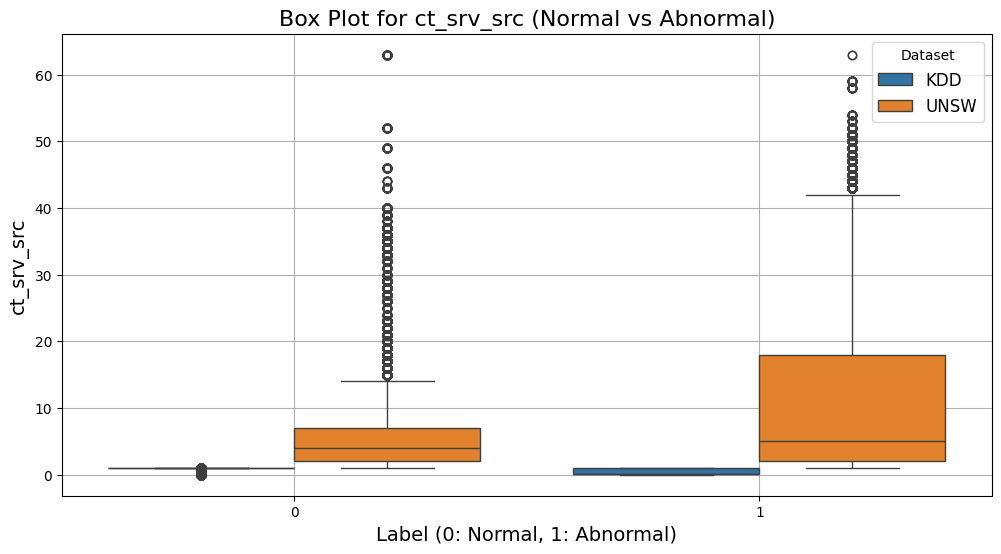

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='sloss'>

Text(0.5, 1.0, 'Box Plot for sloss (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'sloss')

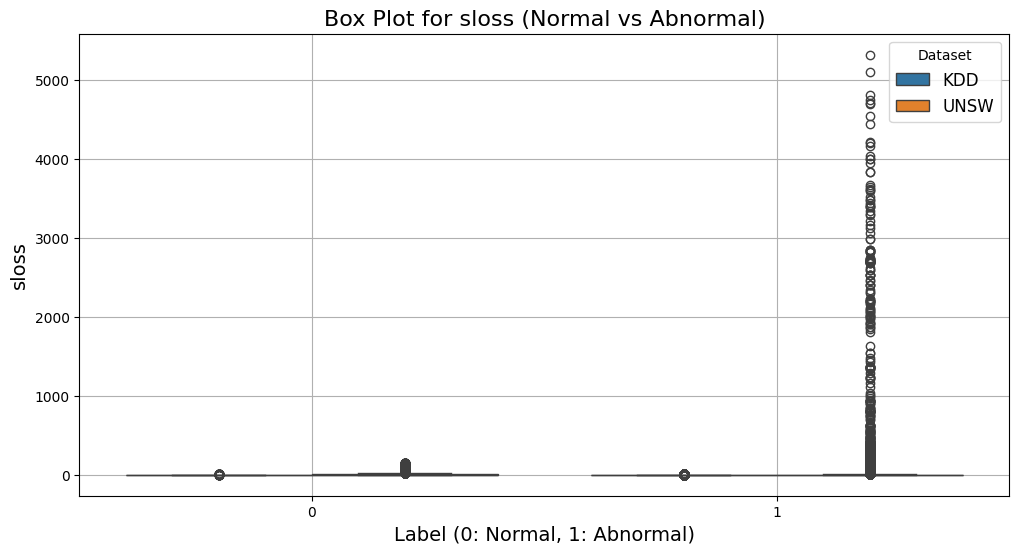

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='ct_dst_ltm'>

Text(0.5, 1.0, 'Box Plot for ct_dst_ltm (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'ct_dst_ltm')

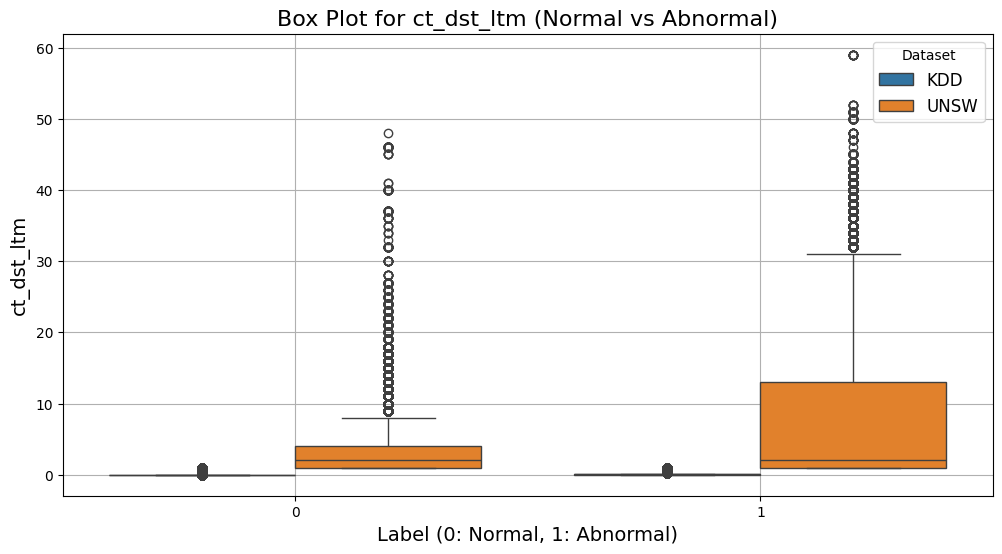

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='proto'>

Text(0.5, 1.0, 'Box Plot for proto (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'proto')

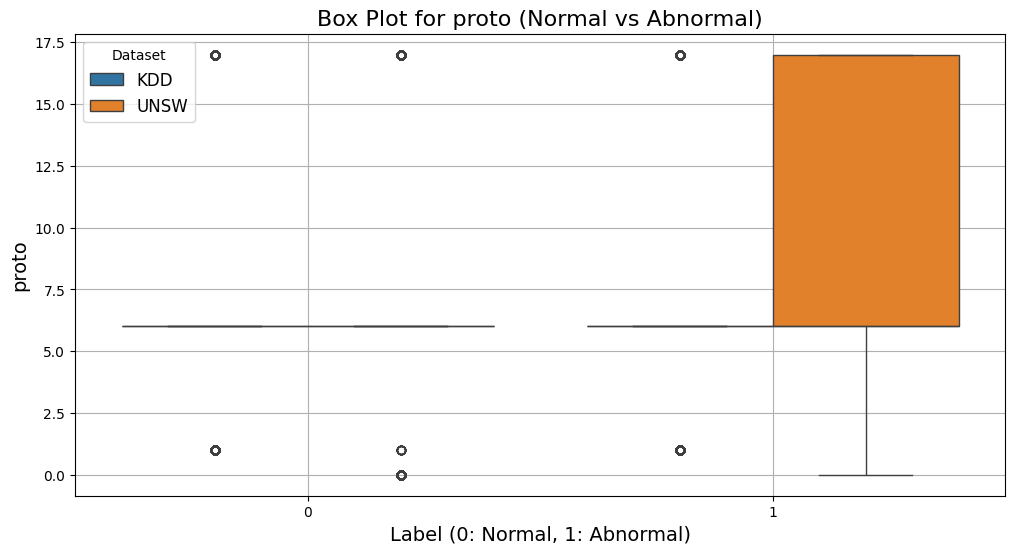

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='dpkts'>

Text(0.5, 1.0, 'Box Plot for dpkts (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'dpkts')

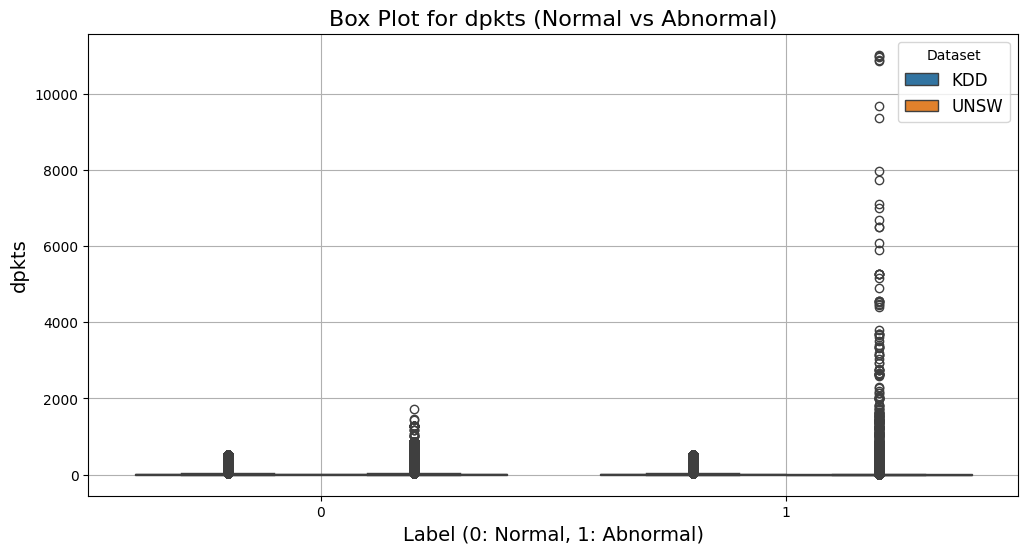

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='dur'>

Text(0.5, 1.0, 'Box Plot for dur (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'dur')

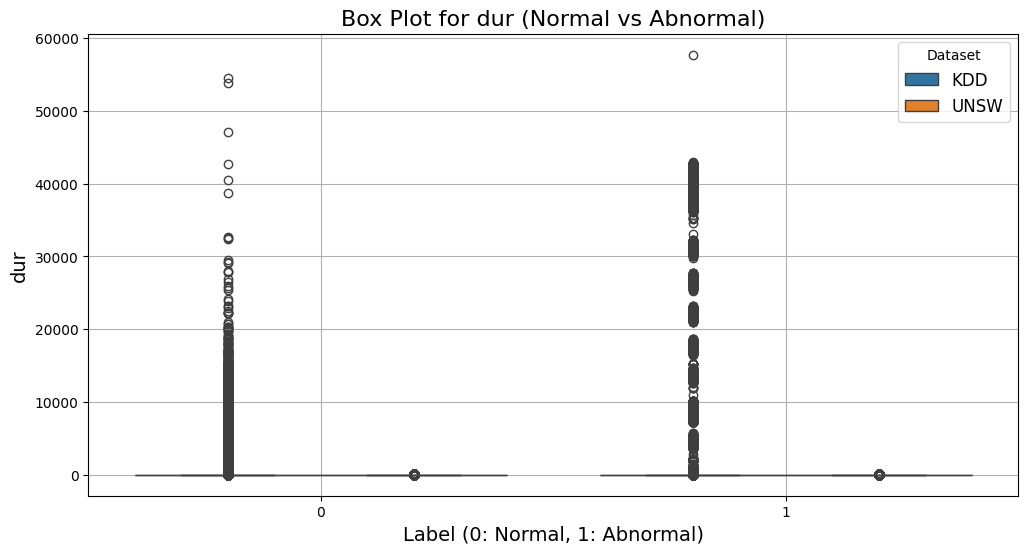

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='service'>

Text(0.5, 1.0, 'Box Plot for service (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'service')

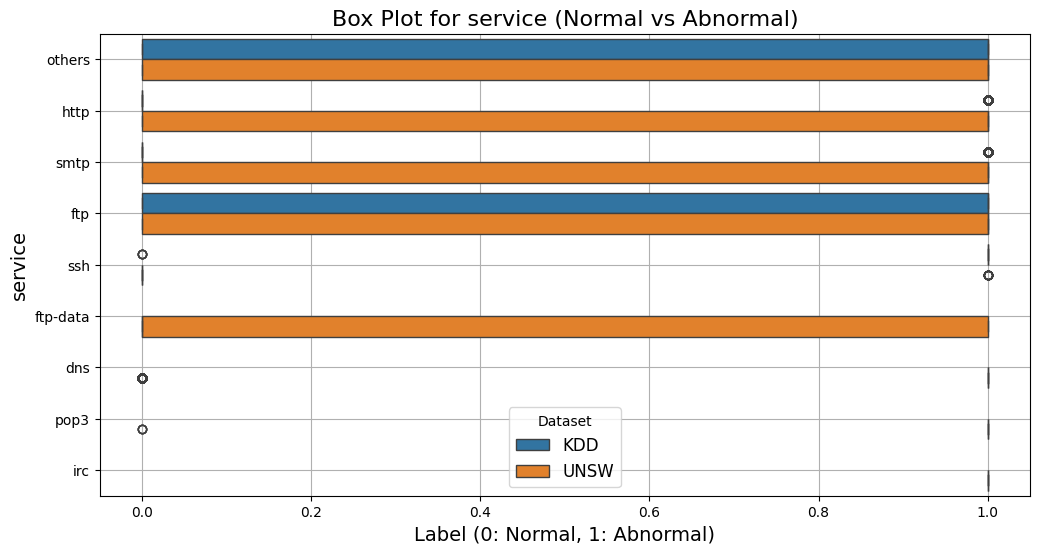

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='spkts'>

Text(0.5, 1.0, 'Box Plot for spkts (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'spkts')

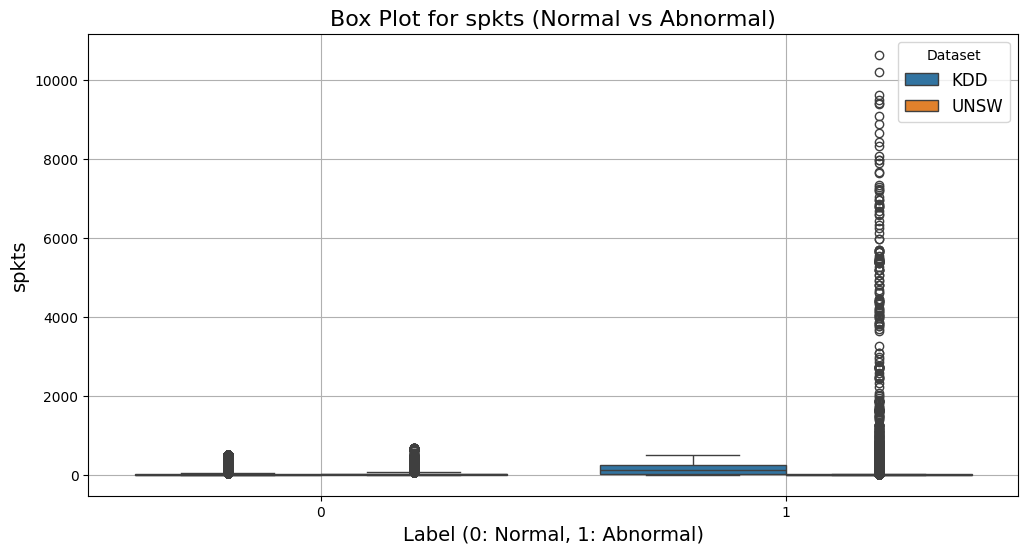

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='dbytes'>

Text(0.5, 1.0, 'Box Plot for dbytes (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'dbytes')

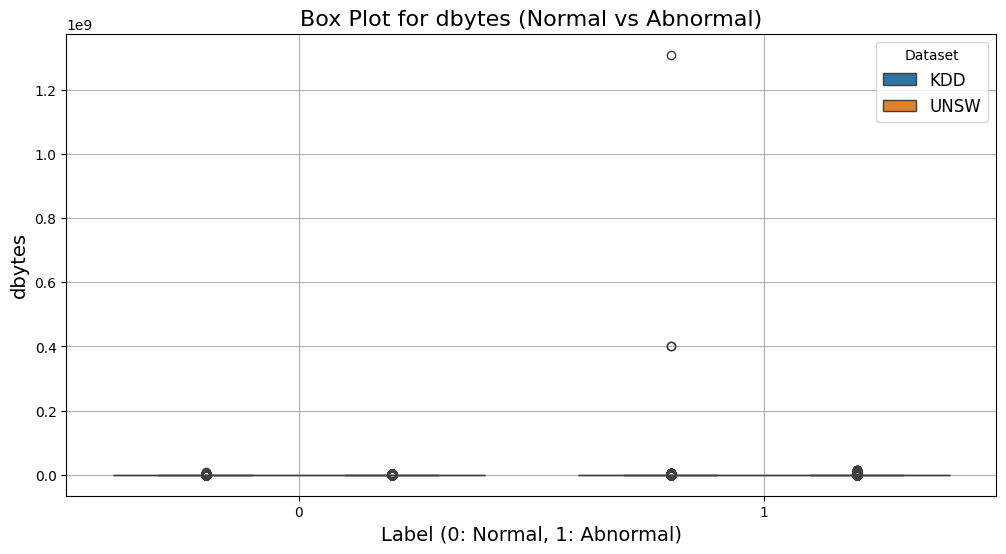

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='smean'>

Text(0.5, 1.0, 'Box Plot for smean (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'smean')

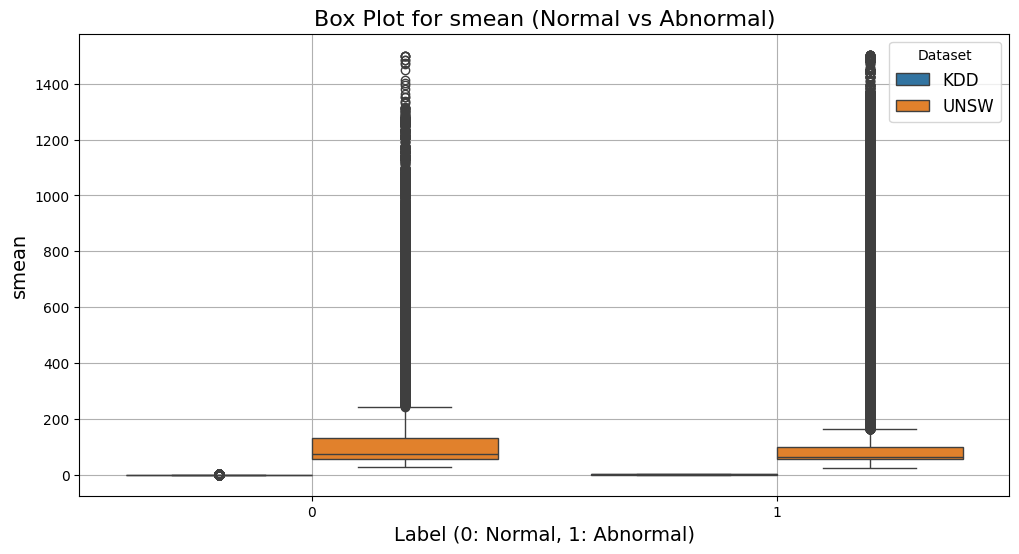

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='is_ftp_login'>

Text(0.5, 1.0, 'Box Plot for is_ftp_login (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'is_ftp_login')

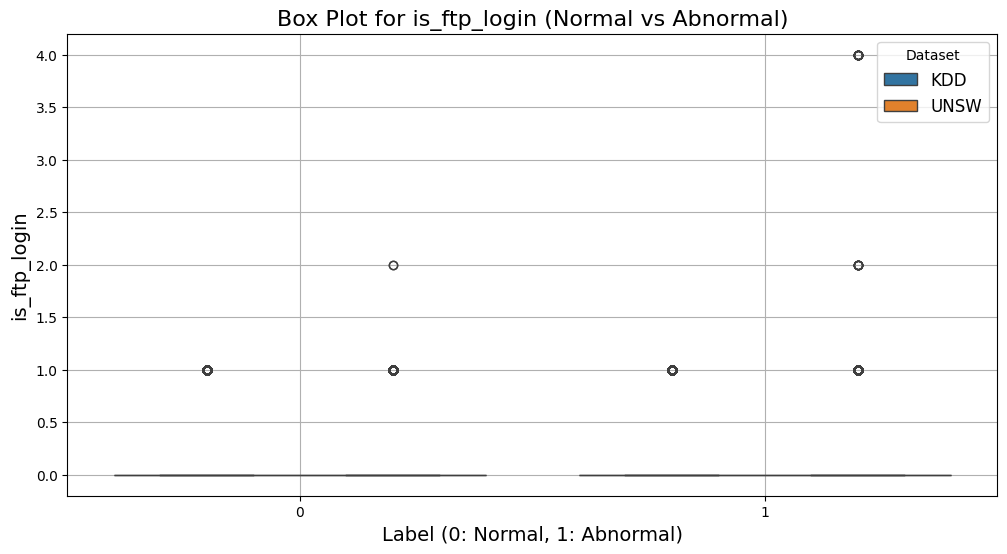

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='sbytes'>

Text(0.5, 1.0, 'Box Plot for sbytes (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'sbytes')

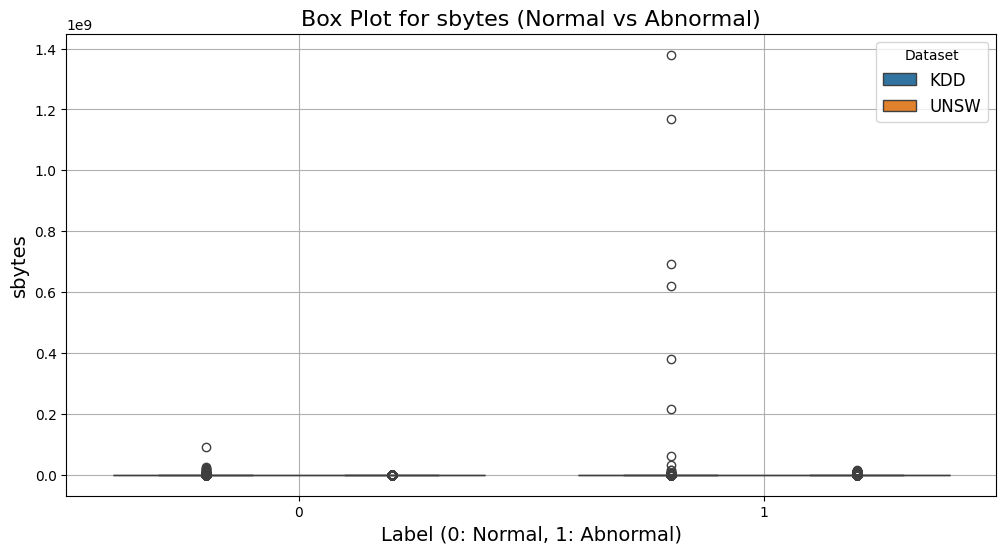

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='dmean'>

Text(0.5, 1.0, 'Box Plot for dmean (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'dmean')

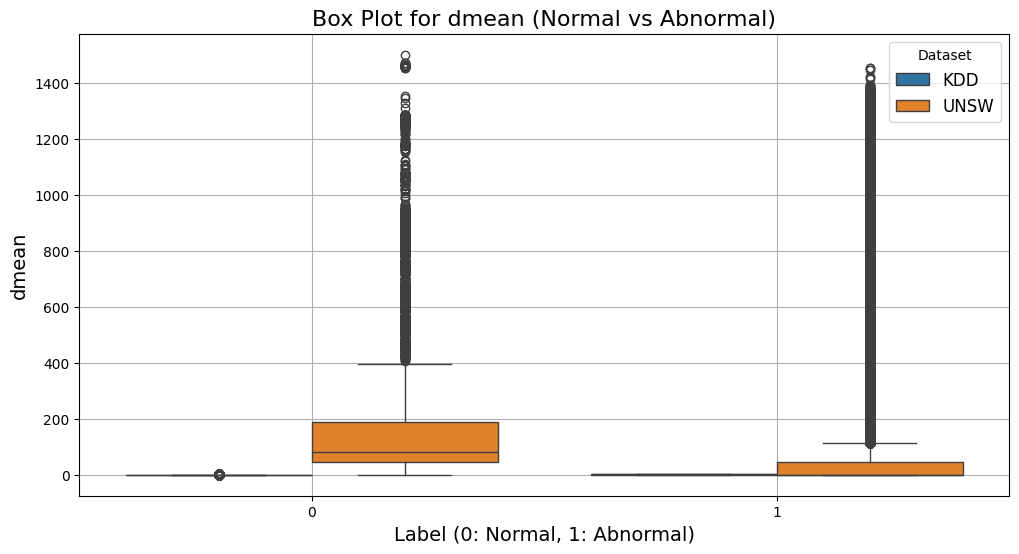

<Figure size 1200x600 with 0 Axes>

/tmp/ipykernel_169/301786948.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_kdd_df[['label', column]].assign(dataset='KDD')


<Axes: xlabel='label', ylabel='dloss'>

Text(0.5, 1.0, 'Box Plot for dloss (Normal vs Abnormal)')

Text(0.5, 0, 'Label (0: Normal, 1: Abnormal)')

Text(0, 0.5, 'dloss')

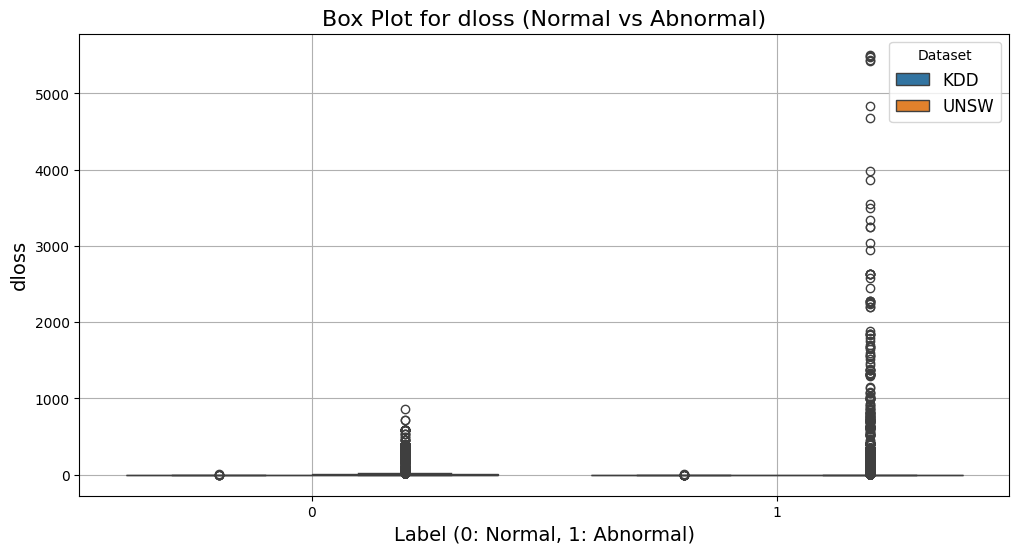

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# 공통 컬럼 가져오기 (label 제외)
common_columns = set(new_kdd_df.columns).intersection(new_unsw_df.columns) - {'label'}

# 각 컬럼별 박스플롯
for column in common_columns:
    plt.figure(figsize=(12, 6))
    
    # 데이터 합치기
    combined_df = (
        new_kdd_df[['label', column]].assign(dataset='KDD')
        .append(new_unsw_df[['label', column]].assign(dataset='UNSW'), ignore_index=True)
    )

    # 박스플롯
    sns.boxplot(data=combined_df, x='label', y=column, hue='dataset')

    # 그래프 꾸미기
    plt.title(f'Box Plot for {column} (Normal vs Abnormal)', fontsize=16)
    plt.xlabel('Label (0: Normal, 1: Abnormal)', fontsize=14)
    plt.ylabel(column, fontsize=14)
    plt.legend(title='Dataset', fontsize=12)
    plt.grid(True)
    plt.show()

1. KDE/Histogram Comparison


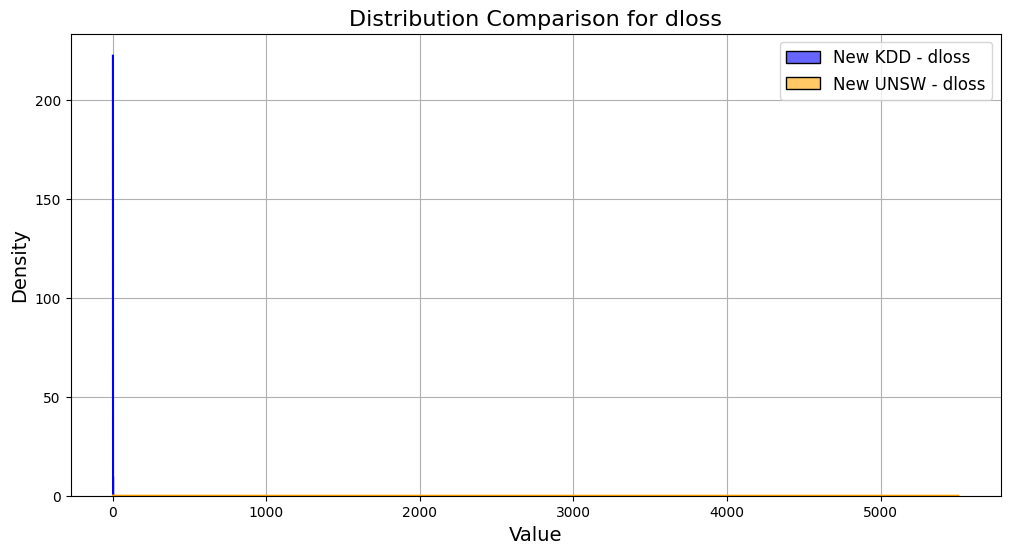

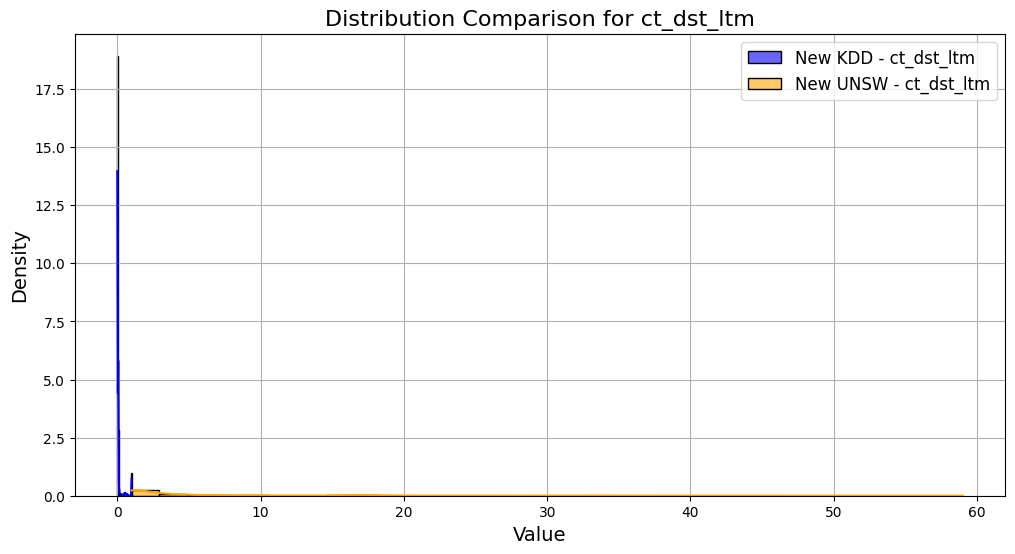

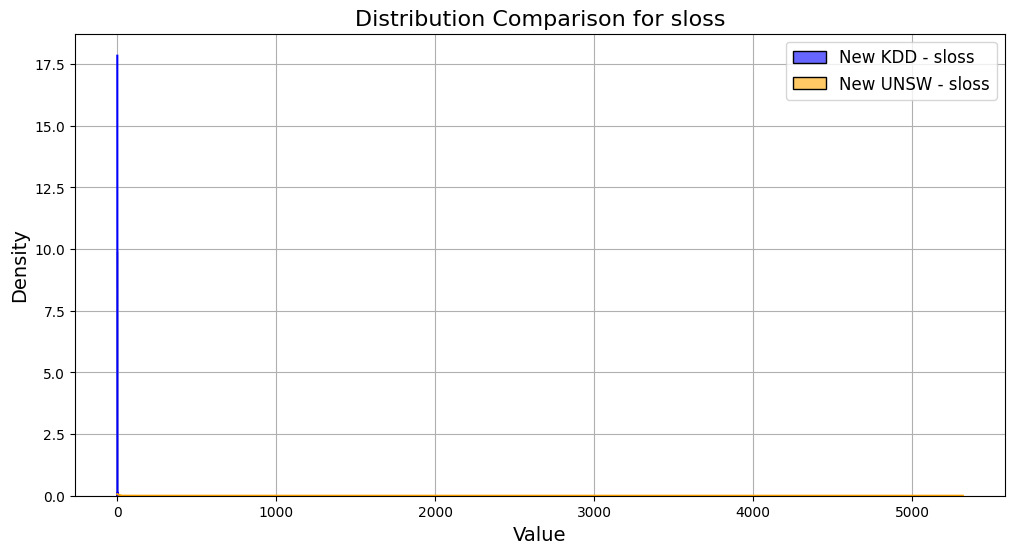

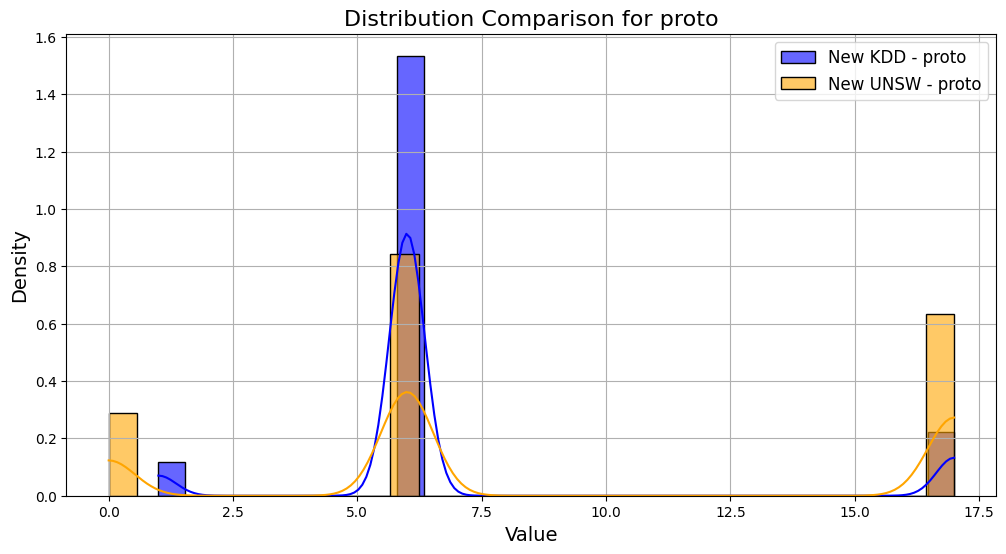

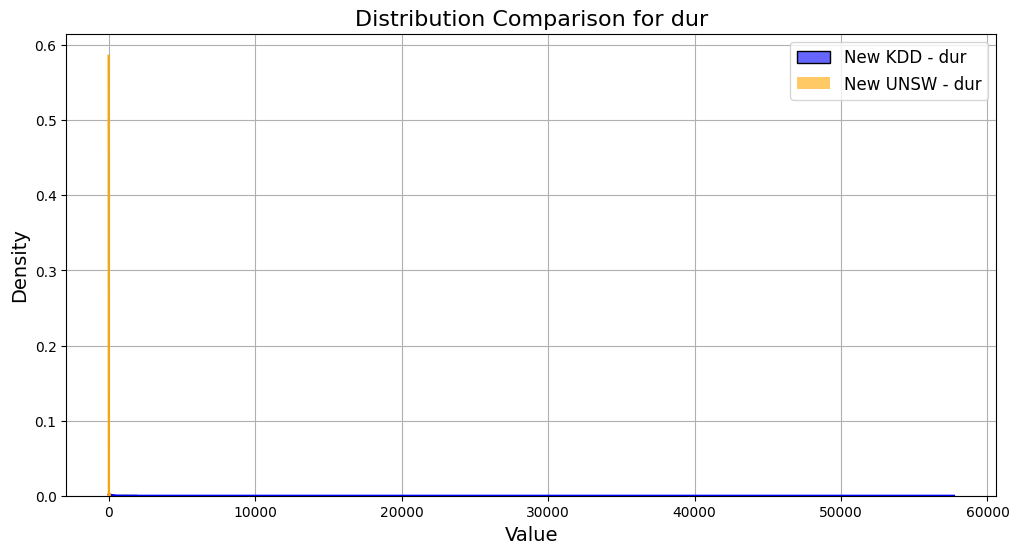

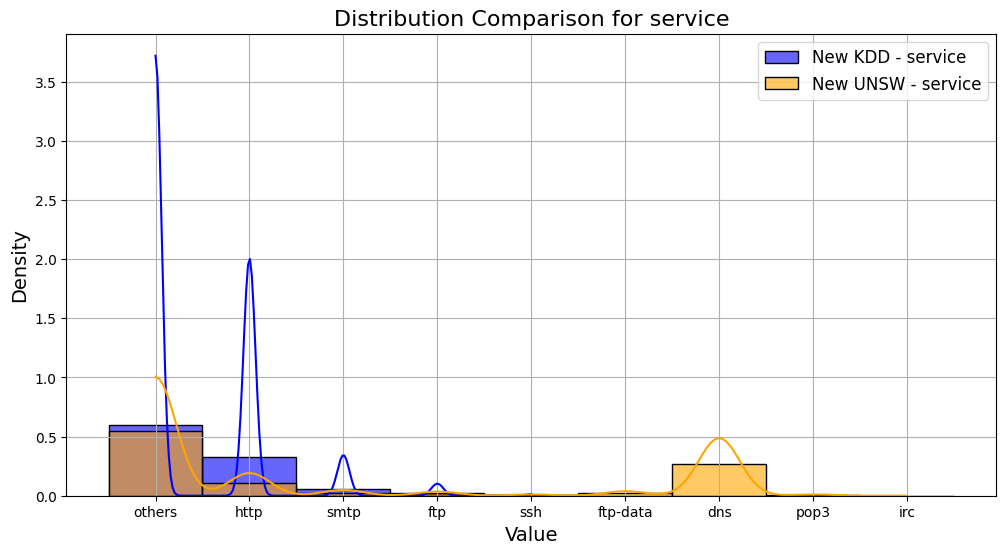

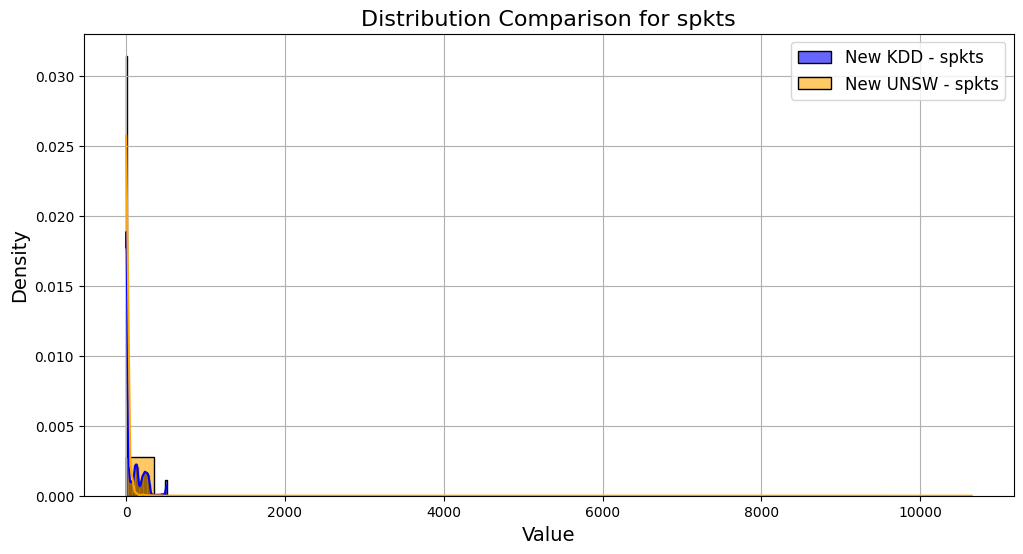

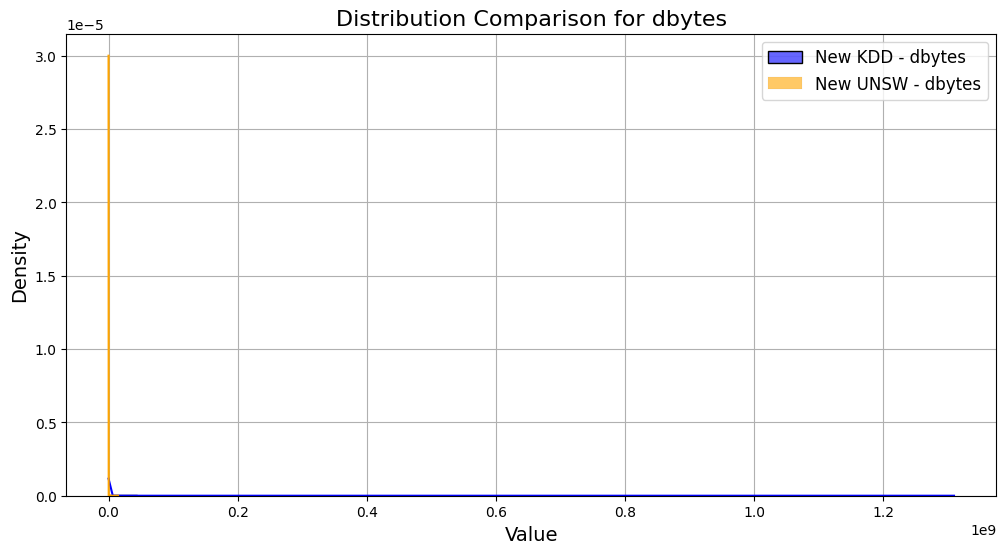

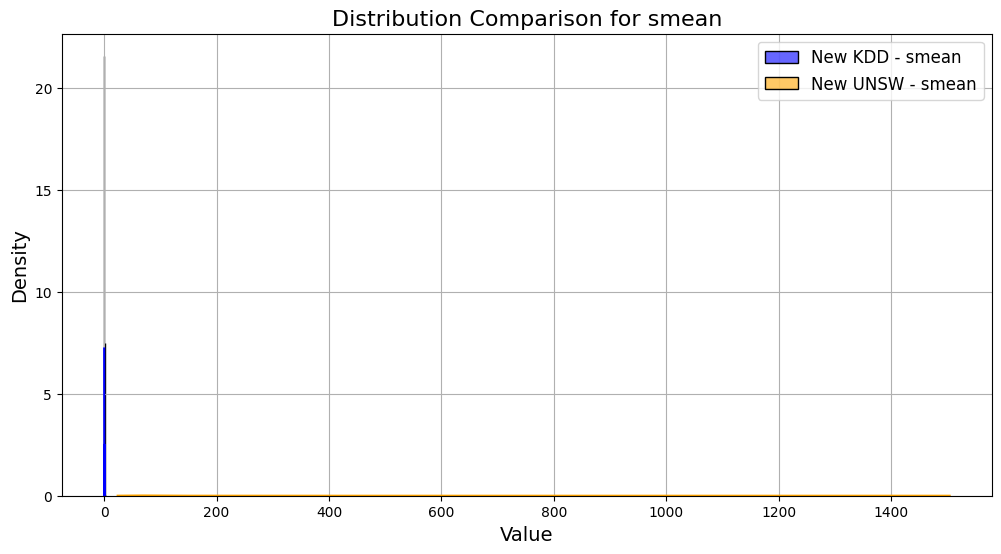

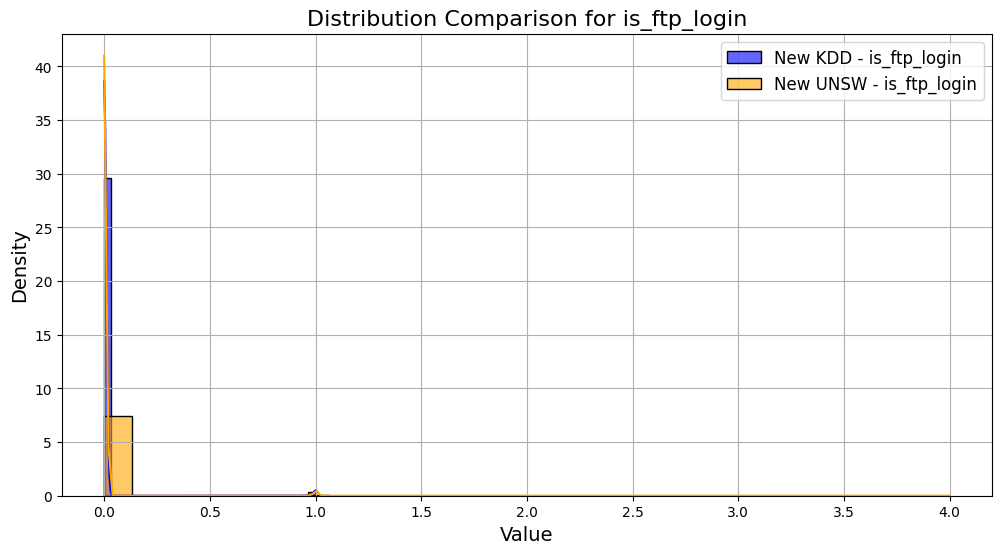

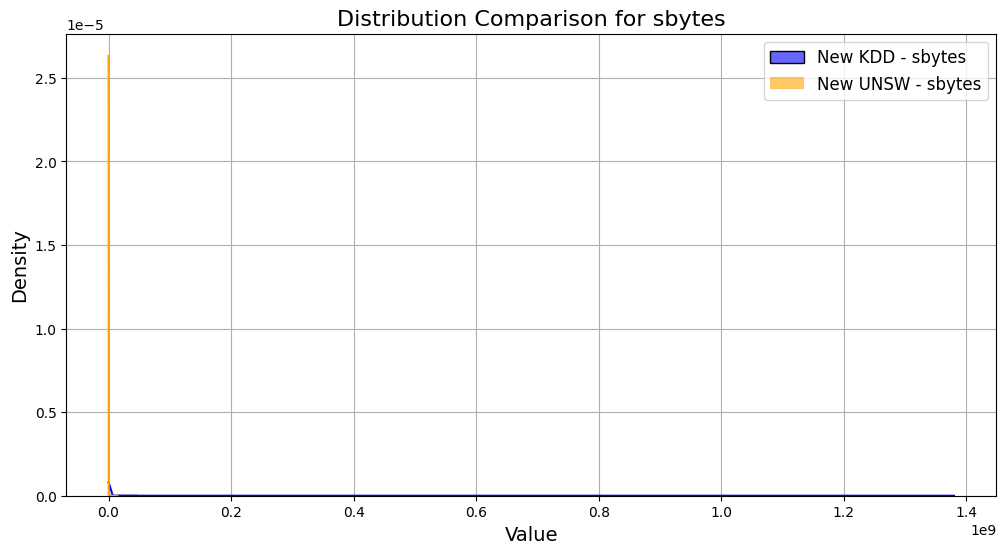

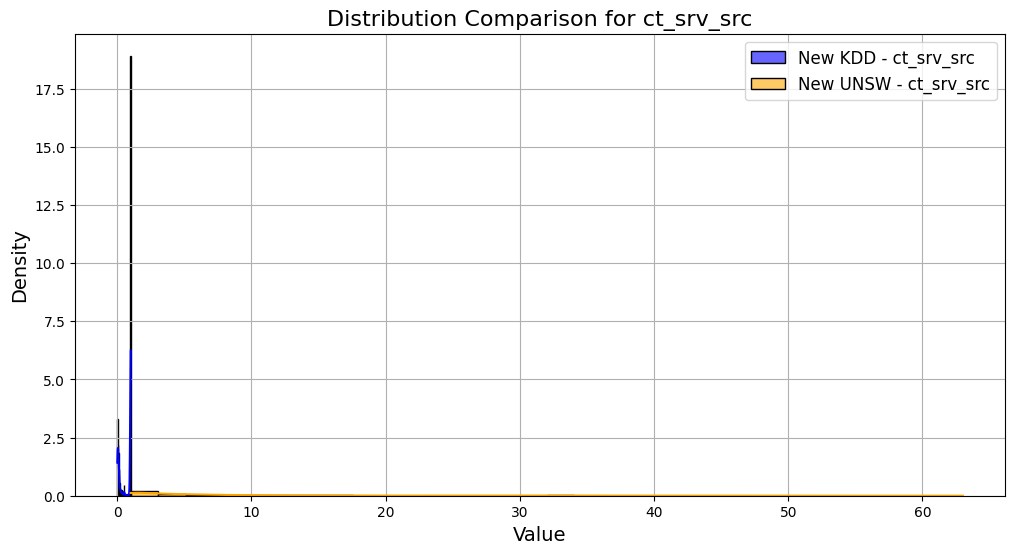

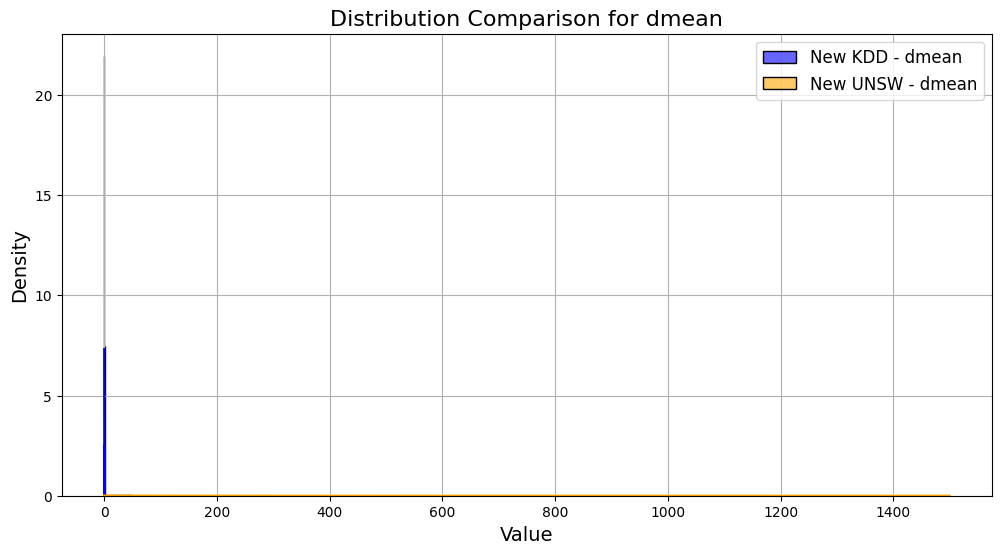

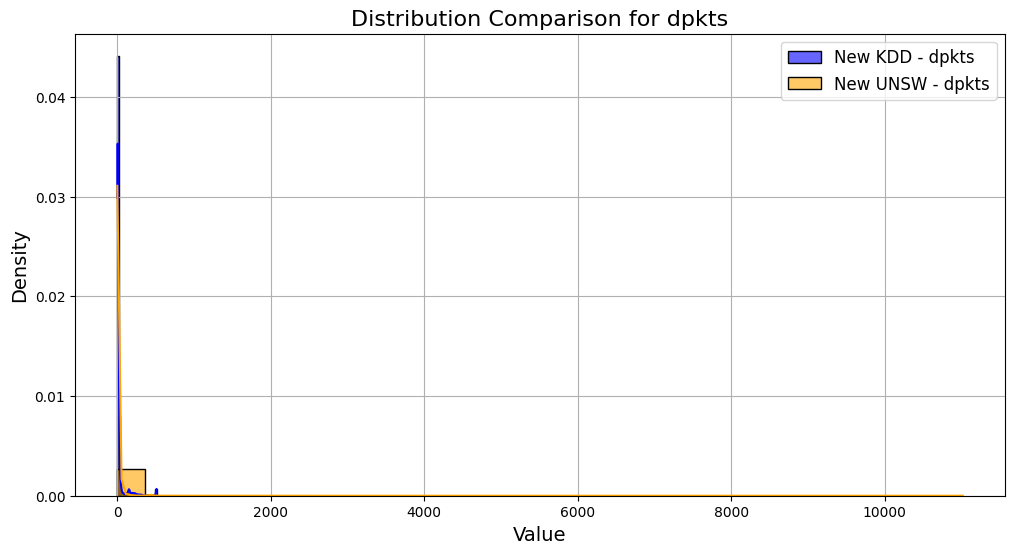

2. Boxplot Comparison


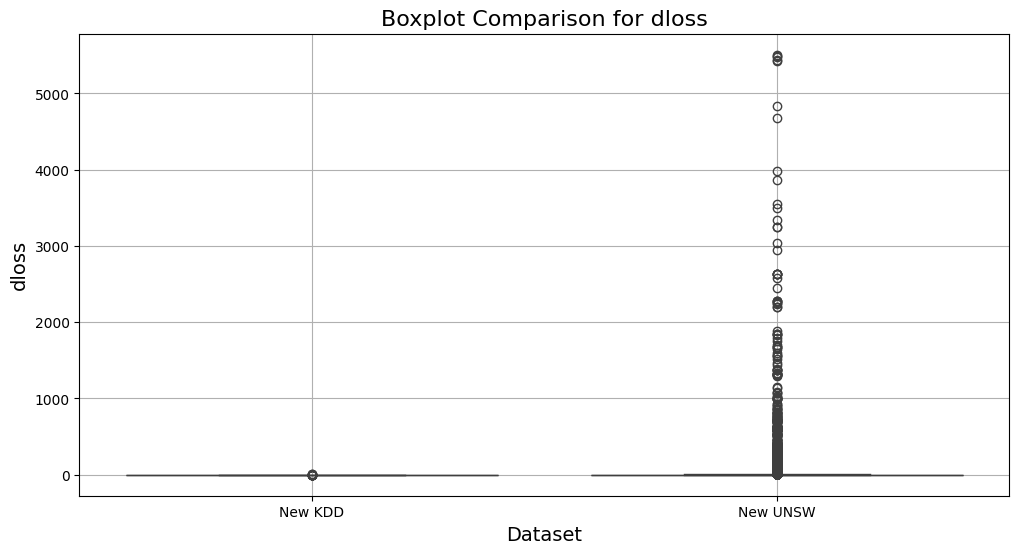

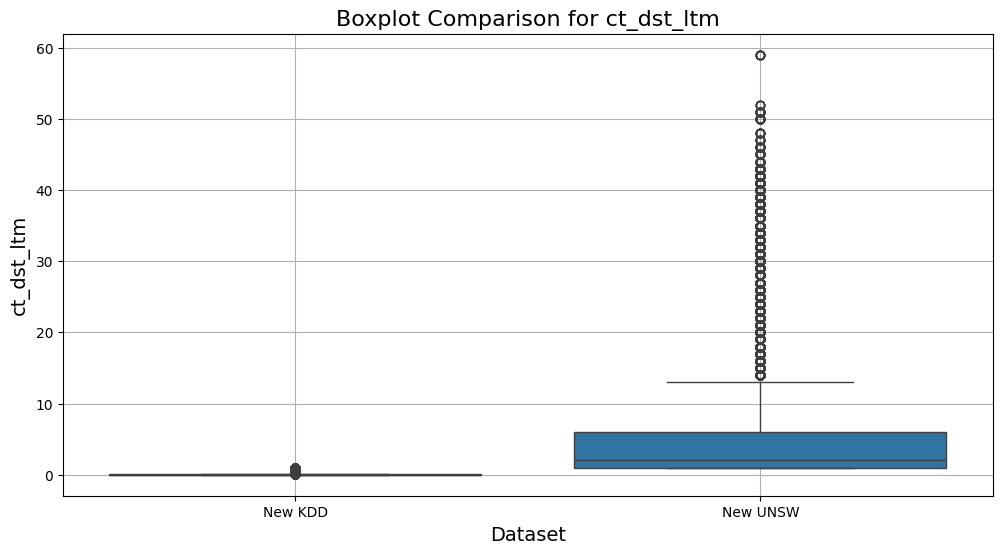

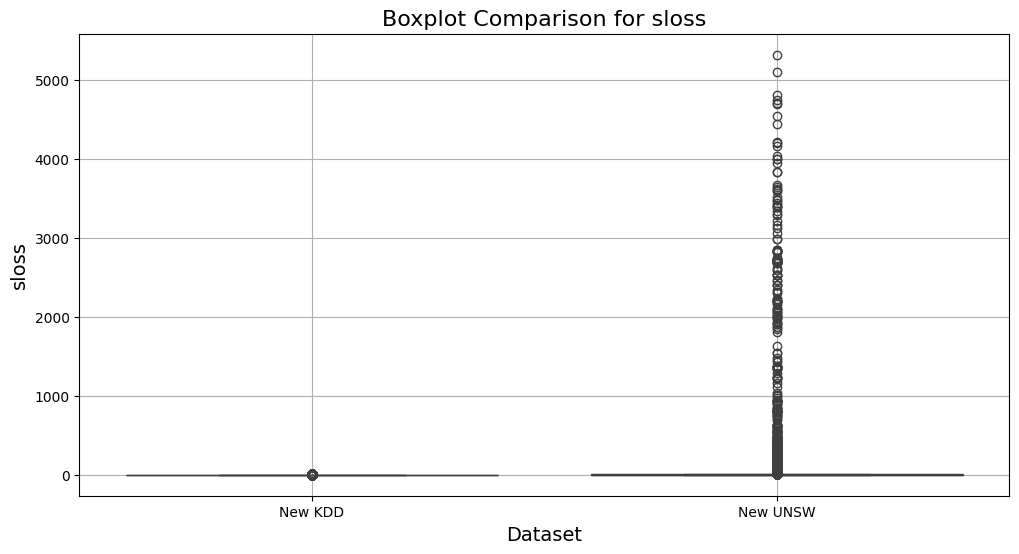

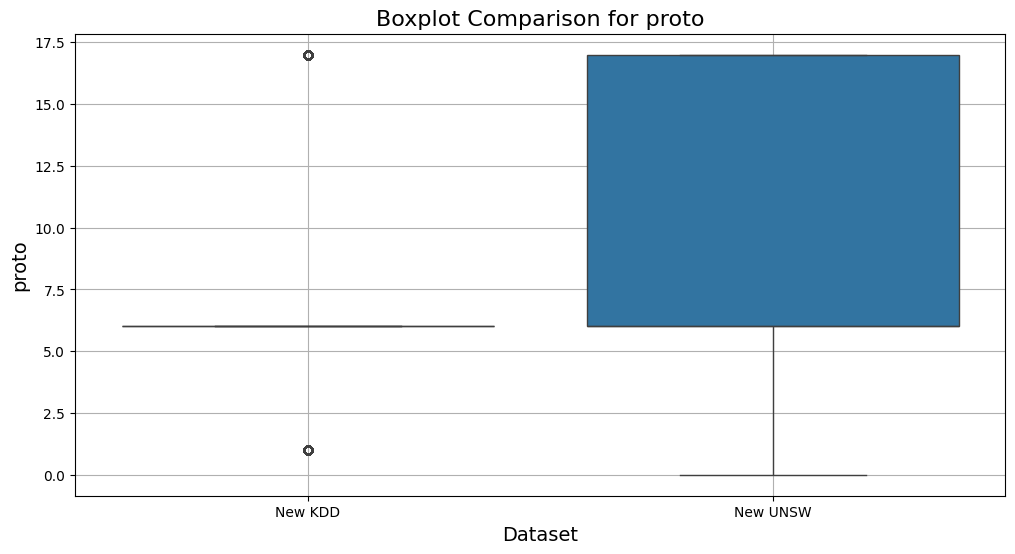

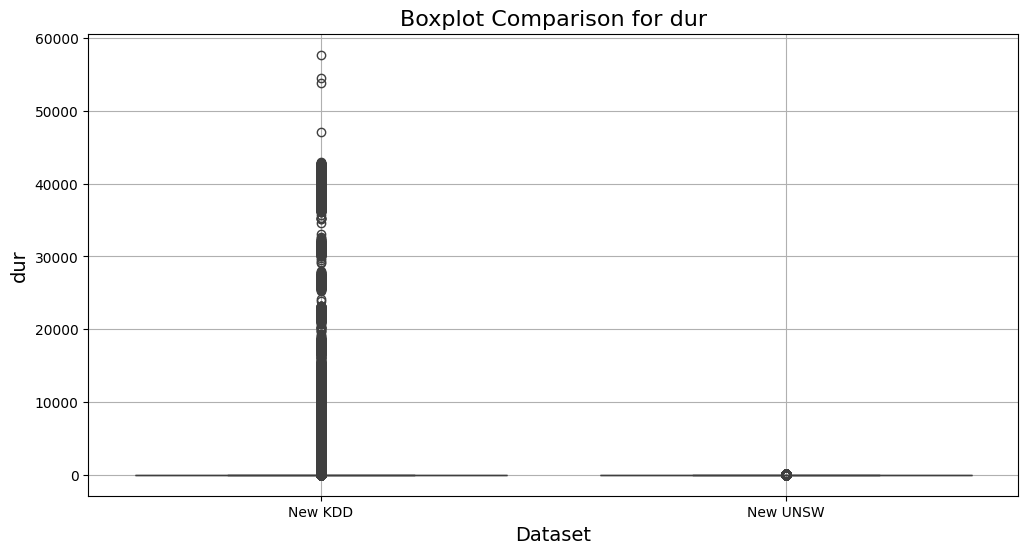

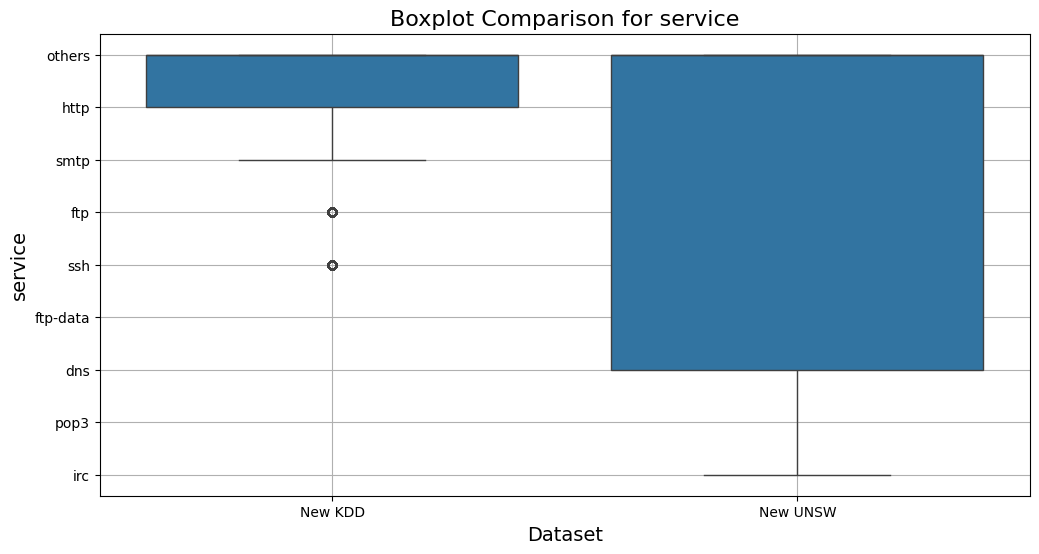

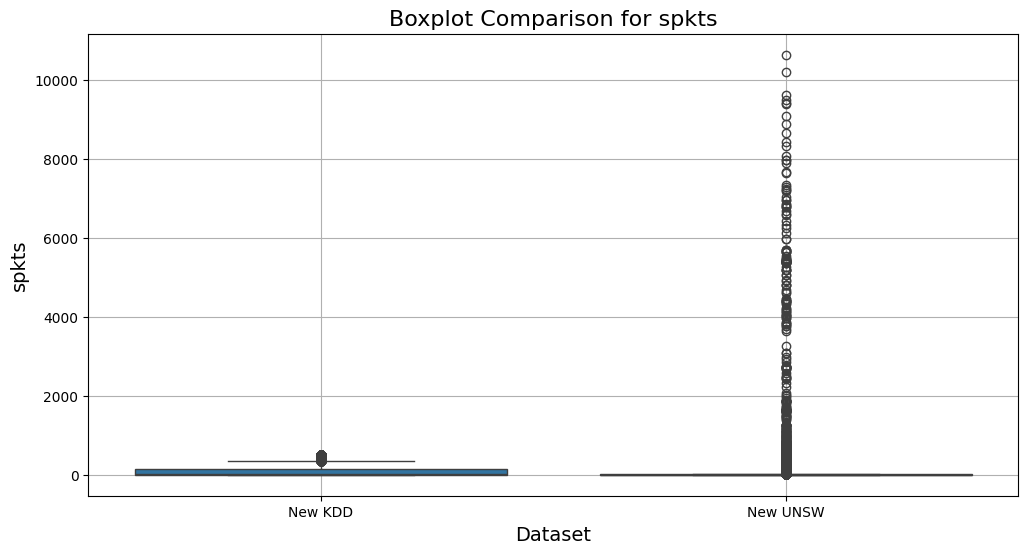

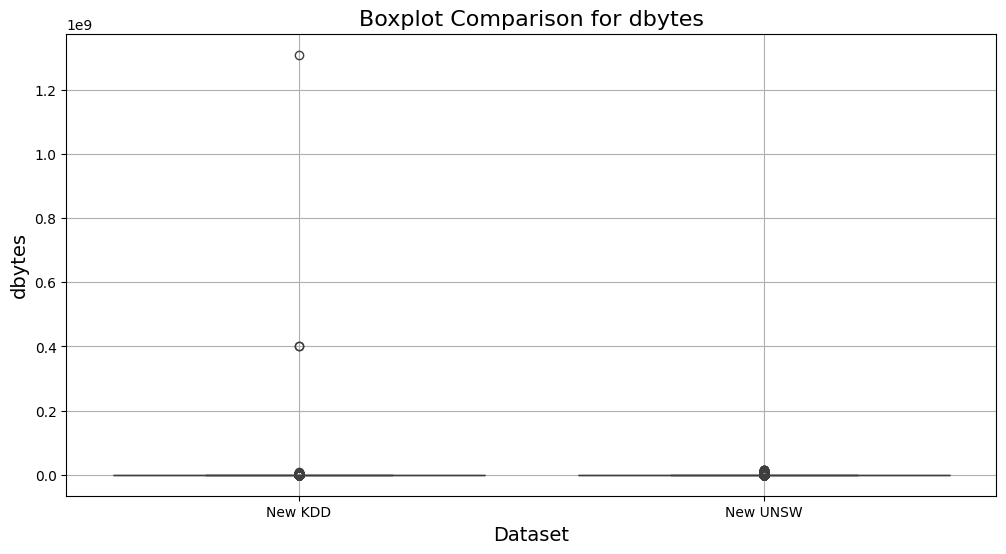

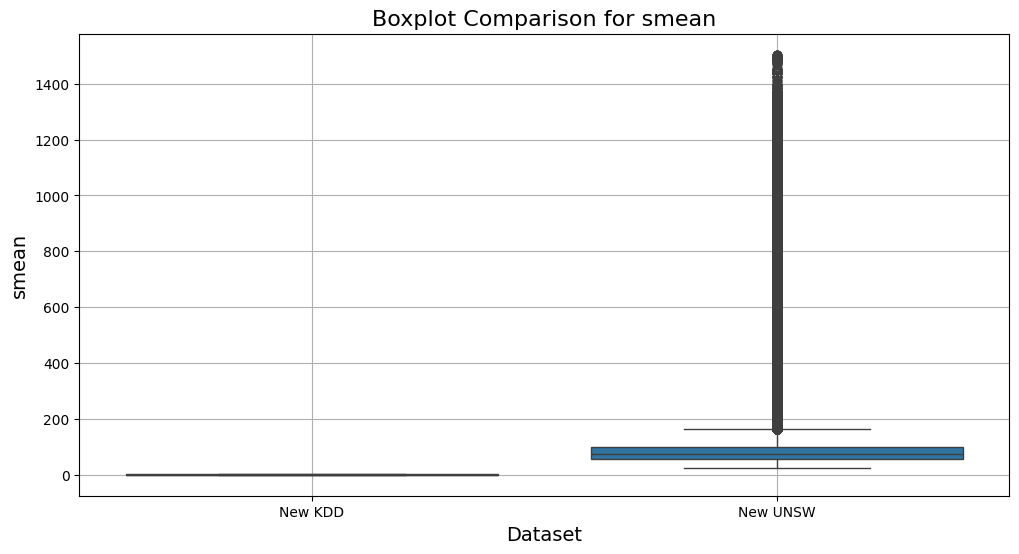

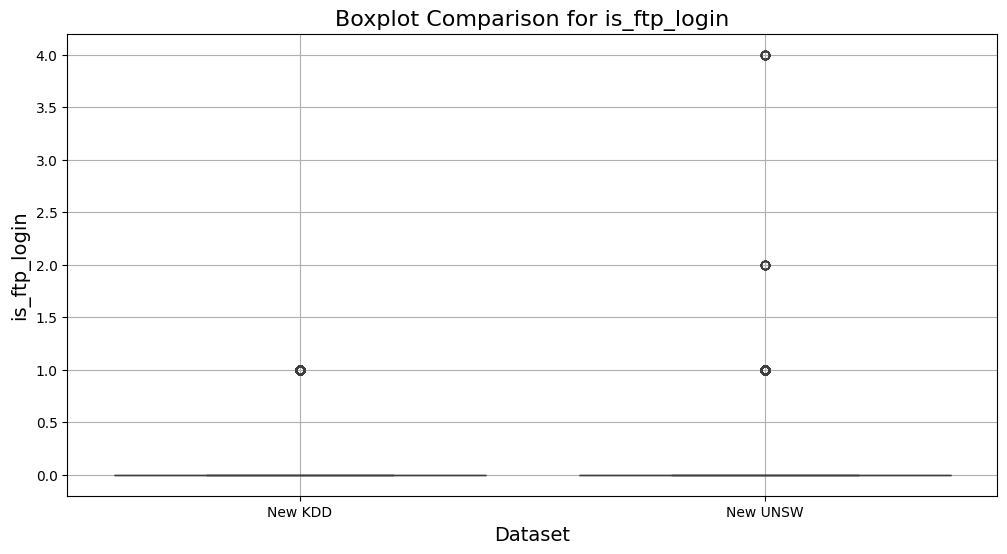

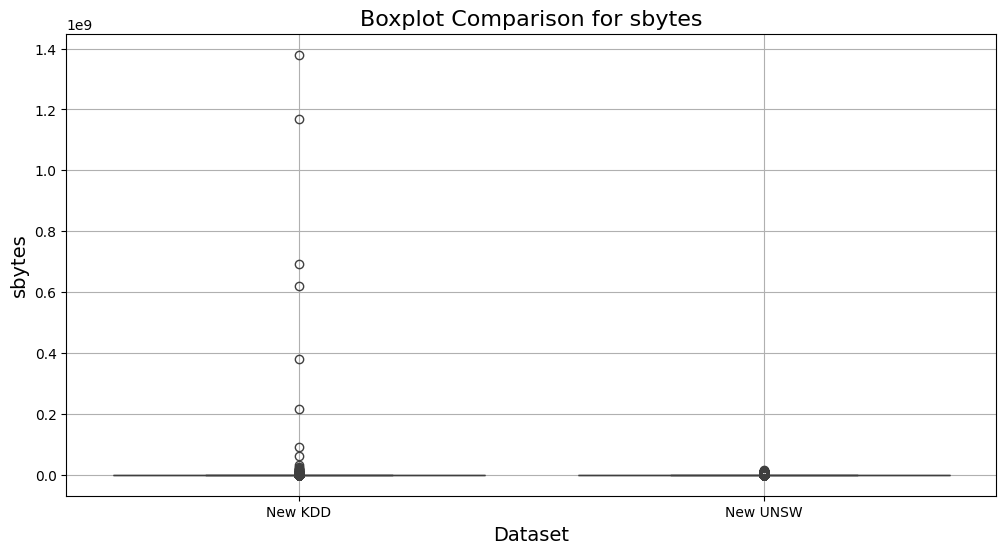

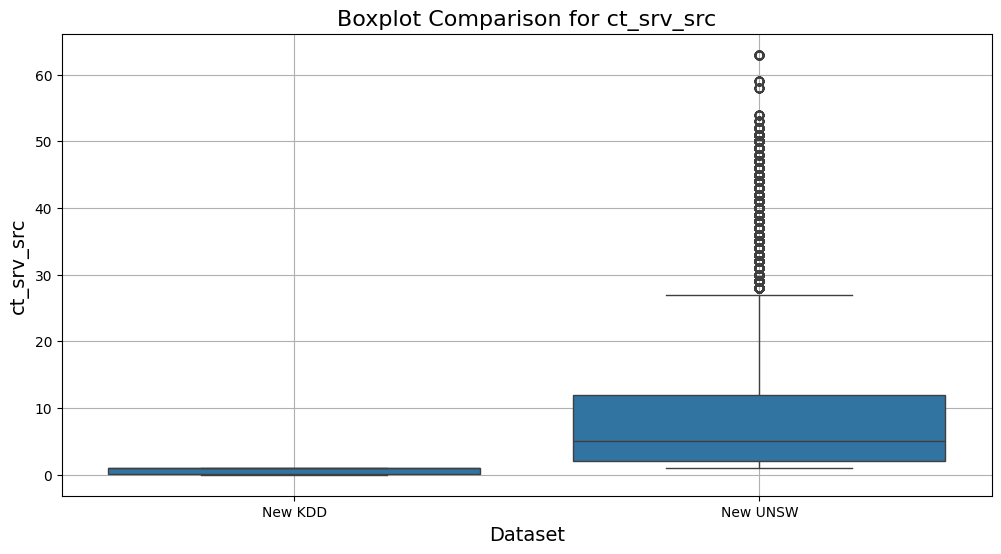

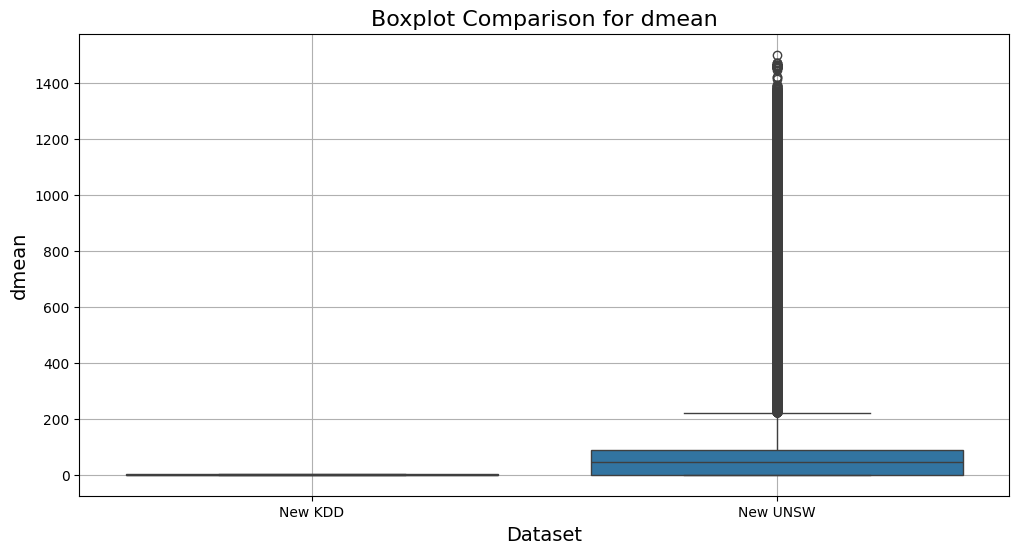

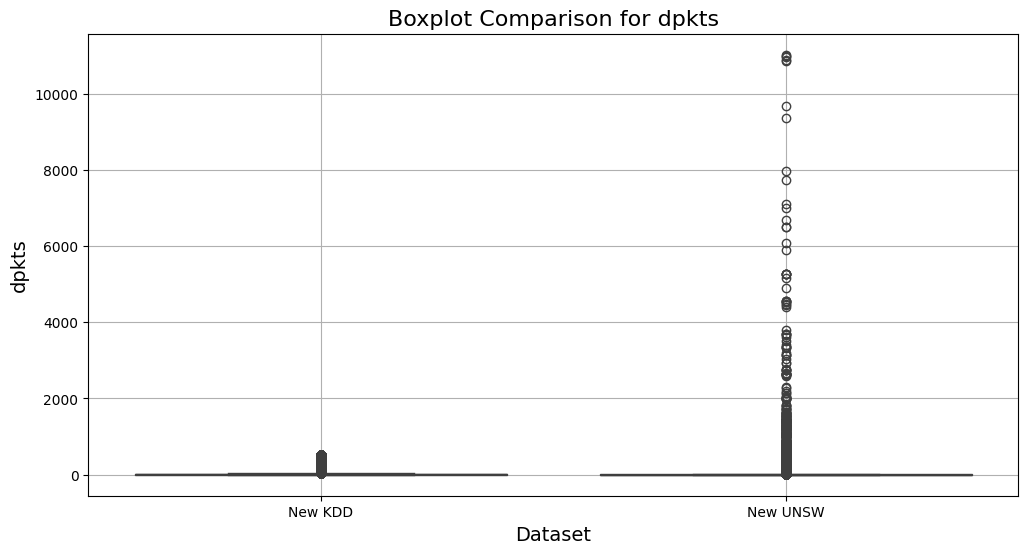

3. PCA Visualization


ValueError: could not convert string to float: 'others'

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# 1. 데이터셋 간 분포 비교: 히스토그램 + KDE
def plot_histogram_kde(data1, data2, columns, data1_label='Dataset 1', data2_label='Dataset 2'):
    for column in columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(data1[column], kde=True, color='blue', label=f'{data1_label} - {column}', stat='density', bins=30, alpha=0.6)
        sns.histplot(data2[column], kde=True, color='orange', label=f'{data2_label} - {column}', stat='density', bins=30, alpha=0.6)
        plt.title(f'Distribution Comparison for {column}', fontsize=16)
        plt.xlabel('Value', fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()

# 2. 데이터셋 간 분포 비교: 박스플롯
def plot_boxplot(data1, data2, columns, data1_label='Dataset 1', data2_label='Dataset 2'):
    combined_data = (
        pd.concat([data1[columns].assign(dataset=data1_label), data2[columns].assign(dataset=data2_label)], ignore_index=True)
    )
    for column in columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=combined_data, x='dataset', y=column)
        plt.title(f'Boxplot Comparison for {column}', fontsize=16)
        plt.xlabel('Dataset', fontsize=14)
        plt.ylabel(column, fontsize=14)
        plt.grid(True)
        plt.show()

# 3. 데이터셋 간 분포 비교: PCA 시각화
def plot_pca(data1, data2, columns, data1_label='Dataset 1', data2_label='Dataset 2'):
    pca = PCA(n_components=2)
    combined_data = pd.concat([data1[columns], data2[columns]])
    labels = [data1_label] * len(data1) + [data2_label] * len(data2)
    pca_result = pca.fit_transform(combined_data)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=pca_result[:len(data1), 0], y=pca_result[:len(data1), 1], label=data1_label, color='blue', alpha=0.5)
    sns.scatterplot(x=pca_result[len(data1):, 0], y=pca_result[len(data1):, 1], label=data2_label, color='orange', alpha=0.5)
    plt.title('PCA Comparison of Two Datasets', fontsize=16)
    plt.xlabel('PCA Component 1', fontsize=14)
    plt.ylabel('PCA Component 2', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# 두 데이터셋의 공통 컬럼 추출
common_columns = list(set(new_kdd_df.columns).intersection(set(new_unsw_df.columns)) - {'label'})

# 분포 시각화 실행
print("1. KDE/Histogram Comparison")
plot_histogram_kde(new_kdd_df, new_unsw_df, common_columns, data1_label='New KDD', data2_label='New UNSW')

print("2. Boxplot Comparison")
plot_boxplot(new_kdd_df, new_unsw_df, common_columns, data1_label='New KDD', data2_label='New UNSW')

print("3. PCA Visualization")
plot_pca(new_kdd_df, new_unsw_df, common_columns, data1_label='New KDD', data2_label='New UNSW')

In [81]:
from scipy.stats import ks_2samp
import pandas as pd

# Kolmogorov-Smirnov Test를 사용한 피처 셀렉션 함수
def select_similar_features(data1, data2, common_columns, threshold=0.05):
    """
    두 데이터셋에서 공통 피처의 분포를 비교하고, 분포가 유사한 피처를 선택합니다.
    
    Parameters:
        data1 (pd.DataFrame): 첫 번째 데이터셋
        data2 (pd.DataFrame): 두 번째 데이터셋
        common_columns (list): 공통 피처 이름 리스트
        threshold (float): KS 테스트의 p-value 임계값 (유사성을 판단하는 기준)
    
    Returns:
        list: 분포가 유사한 피처 이름 리스트
    """
    similar_features = []

    for column in common_columns:
        # KS Test 수행
        stat, p_value = ks_2samp(data1[column], data2[column])
        
        # p-value가 threshold 이상이면 유사하다고 판단
        if p_value > threshold:
            similar_features.append(column)

    return similar_features


# 공통 피처 추출 (label 제외)
common_columns = list(set(kdd_df.columns).intersection(unsw_df.columns) - {'label'})

# 분포가 유사한 피처 선택
similar_features = select_similar_features(kdd_df, unsw_df, common_columns, threshold=0.05)

print(f"분포가 유사한 피처 (p-value > 0.05): {similar_features}")

분포가 유사한 피처 (p-value > 0.05): []


In [92]:
from scipy.stats import wasserstein_distance

# Wasserstein Distance를 사용한 피처 셀렉션 함수
def select_similar_features_wasserstein(data1, data2, common_columns, threshold=0.1):
    """
    두 데이터셋에서 공통 피처의 분포를 비교하고, Wasserstein Distance가 임계값 이하인 피처를 선택합니다.
    
    Parameters:
        data1 (pd.DataFrame): 첫 번째 데이터셋
        data2 (pd.DataFrame): 두 번째 데이터셋
        common_columns (list): 공통 피처 이름 리스트
        threshold (float): Wasserstein Distance 임계값 (분포 차이 판단 기준)
    
    Returns:
        list: 분포가 유사한 피처 이름 리스트
    """
    similar_features = []

    for column in common_columns:
        # Wasserstein Distance 계산
        distance = wasserstein_distance(data1[column], data2[column])
        
        # Distance가 threshold 이하이면 유사하다고 판단
        if distance <= threshold:
            similar_features.append(column)

    return similar_features


# 공통 피처 추출 (label 제외)
common_columns = list(set(tmp_kdd_df.columns).intersection(unsw_df.columns) - {'label'})

# Wasserstein Distance 기반으로 분포가 유사한 피처 선택
similar_features_wasserstein = select_similar_features_wasserstein(tmp_kdd_df, tmp_unsw_df, common_columns, threshold=0.1)

print(f"분포가 유사한 피처 (Wasserstein Distance <= 0.1): {similar_features_wasserstein}")

분포가 유사한 피처 (Wasserstein Distance <= 0.1): []


In [91]:
tmp_kdd_df = kdd_df.drop(labels='service',axis=1)
tmp_unsw_df = unsw_df.drop(labels='service',axis=1)

In [93]:
import difflib

def map_similar_columns(columns1, columns2, threshold=0.7):
    """
    Map similar column names between two datasets.

    Parameters:
    - columns1: List of column names from dataset 1.
    - columns2: List of column names from dataset 2.
    - threshold: Minimum similarity ratio to consider as a match (default: 0.7).

    Returns:
    - A dictionary where keys are columns from dataset 1 and values are the most similar columns from dataset 2.
    """
    mapping = {}
    
    for col1 in columns1:
        # Find the most similar column in columns2
        best_match = None
        best_ratio = 0
        
        for col2 in columns2:
            ratio = difflib.SequenceMatcher(None, col1, col2).ratio()
            if ratio > best_ratio and ratio >= threshold:
                best_match = col2
                best_ratio = ratio
        
        if best_match:
            mapping[col1] = best_match
    
    return mapping

# Example usage
# Column names from two datasets
columns_dataset1 = tmp_kdd_df.columns
columns_dataset2 = tmp_unsw_df.columns
# Generate the mapping
column_mapping = map_similar_columns(columns_dataset1, columns_dataset2)

# Print the resulting mapping
print("Column Mapping:")
print(column_mapping)

Column Mapping:
{'src_bytes': 'sbytes', 'dst_bytes': 'sbytes', 'is_host_login': 'is_ftp_login', 'is_guest_login': 'is_ftp_login'}


In [95]:
!pip install rapidfuzz

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.2 MB/s eta 0:00:00a 0:00:01


In [96]:
from rapidfuzz import fuzz

def map_similar_columns(columns1, columns2, threshold=70):
    """
    Map similar column names between two datasets.

    Parameters:
    - columns1: List of column names from dataset 1.
    - columns2: List of column names from dataset 2.
    - threshold: Minimum similarity score (default: 70).

    Returns:
    - A dictionary where keys are columns from dataset 1 and values are the most similar columns from dataset 2.
    """
    mapping = {}
    
    for col1 in columns1:
        best_match = None
        best_score = 0
        
        for col2 in columns2:
            score = fuzz.ratio(col1, col2)  # Calculate similarity score
            if score > best_score and score >= threshold:
                best_match = col2
                best_score = score
        
        if best_match:
            mapping[col1] = (best_match, best_score)  # Include similarity score for debugging
    
    return mapping

# Example usage
columns_dataset1 = tmp_kdd_df.columns
columns_dataset2 = tmp_unsw_df.columns

# Generate the mapping
column_mapping = map_similar_columns(columns_dataset1, columns_dataset2)

# Print the resulting mapping with similarity scores
print("Column Mapping (with scores):")
for col1, (col2, score) in column_mapping.items():
    print(f"{col1} -> {col2} (Score: {score})")

Column Mapping (with scores):
src_bytes -> sbytes (Score: 80.0)
dst_bytes -> sbytes (Score: 80.0)
is_host_login -> is_ftp_login (Score: 80.0)
is_guest_login -> is_ftp_login (Score: 76.92307692307692)


In [97]:
!pip install fuzzywuzzy

Defaulting to user installation because normal site-packages is not writeable


In [98]:
from rapidfuzz import fuzz, process

def map_similar_columns(columns1, columns2, threshold=70, partial=True):
    """
    Map similar column names between two datasets using fuzzy matching.

    Parameters:
    - columns1: List of column names from dataset 1.
    - columns2: List of column names from dataset 2.
    - threshold: Minimum similarity score (default: 70).
    - partial: Use partial ratio for substring matches (default: True).

    Returns:
    - A dictionary where keys are columns from dataset 1 and values are the most similar columns from dataset 2.
    """
    mapping = {}
    
    for col1 in columns1:
        best_match = None
        best_score = 0
        
        for col2 in columns2:
            # Calculate both full and partial similarity
            full_ratio = fuzz.ratio(col1, col2)
            partial_ratio = fuzz.partial_ratio(col1, col2) if partial else 0
            score = max(full_ratio, partial_ratio)  # Use the better score
            
            if score > best_score and score >= threshold:
                best_match = col2
                best_score = score
        
        if best_match:
            mapping[col1] = (best_match, best_score)  # Include similarity score for debugging
    
    return mapping

# Example usage
columns_dataset1 = tmp_kdd_df.columns
columns_dataset2 = tmp_unsw_df.columns

# Generate the mapping
column_mapping = map_similar_columns(columns_dataset1, columns_dataset2, threshold=60)  # Lower threshold to include more matches

# Print the resulting mapping with similarity scores
print("Column Mapping (with scores):")
for col1, (col2, score) in column_mapping.items():
    print(f"{col1} -> {col2} (Score: {score})")

Column Mapping (with scores):
duration -> dur (Score: 100.0)
protocol_type -> proto (Score: 100.0)
flag -> label (Score: 66.66666666666667)
src_bytes -> sbytes (Score: 90.9090909090909)
dst_bytes -> sbytes (Score: 90.9090909090909)
land -> sload (Score: 75.0)
wrong_fragment -> smean (Score: 66.66666666666667)
urgent -> dur (Score: 80.0)
hot -> proto (Score: 66.66666666666667)
num_failed_logins -> is_ftp_login (Score: 63.1578947368421)
logged_in -> dwin (Score: 75.0)
num_compromised -> id (Score: 66.66666666666667)
root_shell -> proto (Score: 75.0)
su_attempted -> rate (Score: 75.0)
num_root -> proto (Score: 66.66666666666667)
num_file_creations -> rate (Score: 75.0)
num_outbound_cmds -> proto (Score: 60.0)
is_host_login -> is_ftp_login (Score: 80.0)
is_guest_login -> is_ftp_login (Score: 80.0)
srv_count -> ct_srv_src (Score: 62.5)
serror_rate -> rate (Score: 100.0)
srv_serror_rate -> rate (Score: 100.0)
rerror_rate -> rate (Score: 100.0)
srv_rerror_rate -> rate (Score: 100.0)
same_srv_